In [ ]:
!pip install ydata-profiling
!pip install pyodbc
import numpy as np
import os
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns
sns.set()
plt.style.use('seaborn-v0_8')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
import nltk
#nltk.download('popular')
nltk.download('punkt')
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.7/395.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=87a4dbbcb1187406d9b6974dd7ba5e9cd9a8ea7e22507c1f978b66234c9e715e
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.2/346.2 kB 5.4 MB/s eta 0:00:00


<ipython-input-1-8e2cf1aac30e>:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Outliers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Load csv file
output_pkl = '/content/drive/My Drive/Colab Notebooks/ML Project/NBA_cleaned.pkl'
df = pd.read_pickle(output_pkl)

# Display the first few rows of the data
print(df.head())

Mounted at /content/drive
            Player   GP     MIN  FGM  FGA  3PM  3PA  FTM  FTA  TOV  ...  \
0  . Rufukatijiang   20   249.0   56   96    0    0   19   27   21  ...   
1  A'uston Calhoun   50  1360.0  246  558   46  141   96  128   94  ...   
2       A.C. Green  187  3769.0  354  801    1   10  161  229  107  ...   
3    A.D. Vassallo   68  1952.5  394  870  175  434  209  249  150  ...   
4    A.J. Bramlett   98  2842.7  468  884    0    6  176  366  182  ...   

   Playoffs_Indication  final_birth_year  final_height_cm  final_weight_kg  \
0                    0            1998.0              NaN              NaN   
1                    0            1990.0            201.0            106.0   
2                    1            1963.0            206.0            100.0   
3                    0            1986.0            198.0             98.0   
4                    0            1977.0            208.0            103.0   

   height_source_fixed  height_source_original  birth_

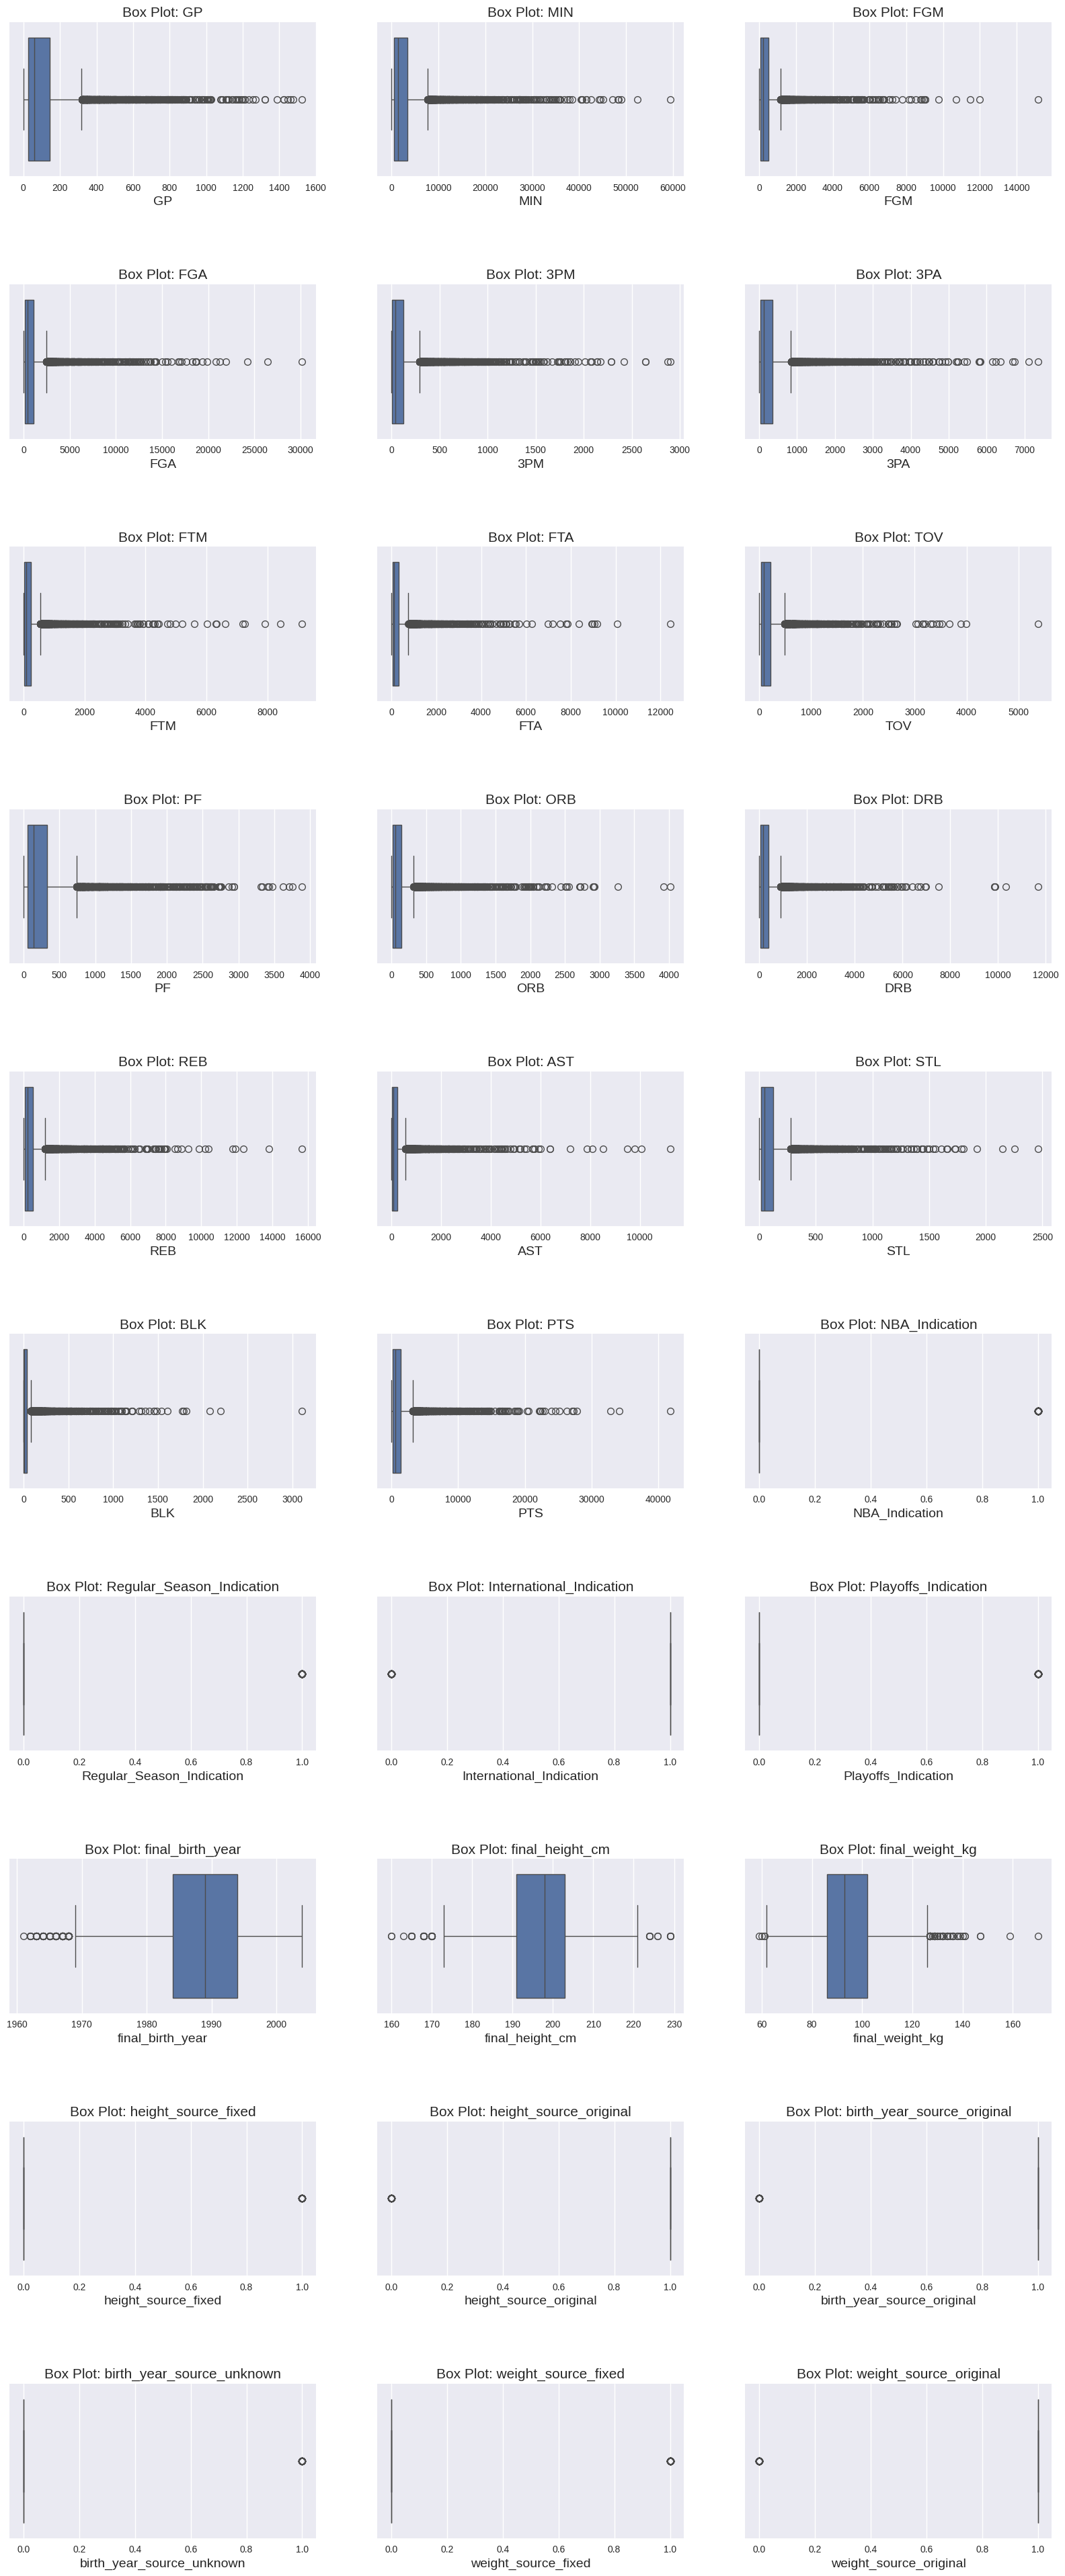

In [ ]:

plt.figure(figsize=(20, len(df.select_dtypes(include=np.number).columns) * 5))

def outliers_boxplot(df):
    numeric_cols = df.select_dtypes(include=np.number).columns  # Take into account only numeric columns
    num_cols = len(numeric_cols)

    for i, col in enumerate(numeric_cols):
        ax = plt.subplot(num_cols, 3, i+1)
        sns.boxplot(data=df, x=col, ax=ax)
        plt.subplots_adjust(hspace=0.7)
        plt.title(f'Box Plot: {col}', fontsize=15)
        plt.xlabel(col, fontsize=14)

outliers_boxplot(df)


Creating Nulls dataframe and matrix

### outliers_df


The data is skewed and not normaly distributed, we'll use the IQR method to identify outliers to set up a boundary before Q1 and after Q3. Any values that fall outside of this boundary are considered outliers:

In [ ]:
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])
    numeric_cols = df.select_dtypes(include=np.number).columns  # Take into account only numeric columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q1 + 1.5 * (Q3-Q1)
        lower_limit = Q3 - 1.5 * (Q3-Q1)

        upper_outliers = df[df[col] > upper_limit]
        lower_outliers = df[df[col] < lower_limit]
        outliers = pd.concat([upper_outliers, lower_outliers])

        num = len(outliers)
        total_outliers.loc[col] = [num, num / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0].sort_values('Percent', ascending=False)

outliers_df = outliers_df(df)
outliers_df


,Outlier count,Percent
BLK,2717.0,18.632561
3PA,2566.0,17.597037
3PM,2548.0,17.473598
ORB,2522.0,17.295296
weight_source_fixed,2488.0,17.062131
weight_source_original,2488.0,17.062131
AST,2484.0,17.034700
REB,2434.0,16.691812
FTM,2433.0,16.684954
STL,2416.0,16.568372


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

outliers_df.to_csv('/content/drive/My Drive/Colab Notebooks/ML Project/outliers_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.path.exists('/content/drive/My Drive/Colab Notebooks/ML Project/outliers_df.csv')


True

### new_outliers_df

Labeling every outlier with 'Outlier' in order to seperate the outliers from nulls (temporarily, and then to 0/1):

In [ ]:
import numpy as np  # Import numpy for numerical operations

def outliers(df):
    """
    Identifies outliers in a DataFrame and labels them as 'Outlier'.
    Outliers are determined using the interquartile range (IQR) method.
    """

    label_out_df = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original data

    for col in label_out_df:  # Iterate over each column in the DataFrame
        if col in outliers_df.index:  # Check if the column is listed in 'outliers_df' (this variable needs to be defined elsewhere)

            Q1 = label_out_df[col].quantile(0.25)  # Calculate the first quartile (25th percentile)
            Q3 = label_out_df[col].quantile(0.75)  # Calculate the third quartile (75th percentile)

            # Compute the upper and lower limits for detecting outliers
            upper_limit = Q1 + 1.5 * (Q3 - Q1)  # Upper limit for detecting outliers
            lower_limit = Q3 - 1.5 * (Q3 - Q1)  # Lower limit for detecting outliers (should be Q1 - 1.5*(Q3-Q1), seems to be a mistake)

            # Replace values greater than the upper limit or less than the lower limit with the label 'Outlier'
            label_out_df[col] = np.where(label_out_df[col] > upper_limit, 'Outlier',
                                         np.where(label_out_df[col] < lower_limit, 'Outlier', label_out_df[col]))

    return label_out_df  # Return the modified DataFrame with outliers labeled

# Apply the function to the DataFrame and display the first 10 rows
new_df_outliers = outliers(df)
new_df_outliers.head(10)


,Player,GP,MIN,FGM,FGA,3PM,3PA,FTM,FTA,TOV,...,Playoffs_Indication,final_birth_year,final_height_cm,final_weight_kg,height_source_fixed,height_source_original,birth_year_source_original,birth_year_source_unknown,weight_source_fixed,weight_source_original
0,. Rufukatijiang,20,249.0,56,96,0,0,19,27,21,...,0,1998.0,nan,nan,Outlier,Outlier,1,0,Outlier,Outlier
1,A'uston Calhoun,50,1360.0,246,558,46,141,96,128,94,...,0,1990.0,201.0,106.0,0,1,1,0,0,1
2,A.C. Green,187,3769.0,354,801,1,10,161,229,107,...,Outlier,Outlier,206.0,100.0,0,1,1,0,0,1
3,A.D. Vassallo,68,1952.5,394,870,175,434,209,249,150,...,0,1986.0,198.0,98.0,0,1,1,0,0,1
4,A.J. Bramlett,98,2842.7,468,884,0,6,176,366,182,...,0,Outlier,208.0,103.0,0,1,1,0,0,1
5,A.J. Davis,35,814.8,132,293,25,98,71,94,89,...,0,1987.0,198.0,95.0,0,1,1,0,0,1
6,A.J. Gasporra,33,500.3,69,147,34,78,42,49,25,...,0,1989.0,191.0,84.0,0,1,1,0,0,1
7,A.J. Guyton,27,800.0,126,302,59,170,47,65,43,...,0,Outlier,185.0,82.0,0,1,1,0,0,1
8,A.J. Hess,38,992.4,160,387,70,204,72,84,49,...,0,1994.0,201.0,95.0,0,1,1,0,0,1
9,A.J. Matthews,36,678.7,148,258,0,0,55,102,64,...,0,1989.0,Outlier,100.0,0,1,1,0,0,1


### df_outliers

Creating a dataframe with outliers as 1 and non-outliers as 0:

In [ ]:
df_outliers = new_df_outliers.isin(['Outlier'])
df_outliers = df_outliers.astype('int')
df_outliers

,Player,GP,MIN,FGM,FGA,3PM,3PA,FTM,FTA,TOV,...,Playoffs_Indication,final_birth_year,final_height_cm,final_weight_kg,height_source_fixed,height_source_original,birth_year_source_original,birth_year_source_unknown,weight_source_fixed,weight_source_original
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14577,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14579,0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we have a dataframe saving all the outliers we'll convert all the outliers to nulls, just so I can see differences in distribution with and without outliers and then decide which of the outliers to remove or not:

In [ ]:
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in outliers_df.index:
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit, np.nan,
                                 np.where(temp[col] < lower_limit, np.nan, temp[col]))
    return temp

temp = capping(df)
temp


,Player,GP,MIN,FGM,FGA,3PM,3PA,FTM,FTA,TOV,...,Playoffs_Indication,final_birth_year,final_height_cm,final_weight_kg,height_source_fixed,height_source_original,birth_year_source_original,birth_year_source_unknown,weight_source_fixed,weight_source_original
0,. Rufukatijiang,20.0,249.0,56.0,96.0,0.0,0.0,19.0,27.0,21.0,...,0.0,1998.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN
1,A'uston Calhoun,50.0,1360.0,246.0,558.0,46.0,141.0,96.0,128.0,94.0,...,0.0,1990.0,201.0,106.0,0.0,1.0,1.0,0.0,0.0,1.0
2,A.C. Green,187.0,3769.0,354.0,801.0,1.0,10.0,161.0,229.0,107.0,...,NaN,NaN,206.0,100.0,0.0,1.0,1.0,0.0,0.0,1.0
3,A.D. Vassallo,68.0,1952.5,394.0,870.0,175.0,434.0,209.0,249.0,150.0,...,0.0,1986.0,198.0,98.0,0.0,1.0,1.0,0.0,0.0,1.0
4,A.J. Bramlett,98.0,2842.7,468.0,884.0,0.0,6.0,176.0,366.0,182.0,...,0.0,NaN,208.0,103.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14577,Zygimantas Jonusas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1982.0,201.0,98.0,0.0,1.0,1.0,0.0,0.0,1.0
14578,Zygimantas Riauka,30.0,507.2,80.0,148.0,0.0,0.0,51.0,70.0,35.0,...,0.0,1993.0,206.0,107.0,0.0,1.0,1.0,0.0,0.0,1.0
14579,Zygimantas Skucas,NaN,4392.3,605.0,1257.0,113.0,389.0,NaN,NaN,NaN,...,0.0,1992.0,201.0,98.0,0.0,1.0,1.0,0.0,0.0,1.0
14580,Zygis Sestokas,42.0,784.3,90.0,201.0,58.0,138.0,28.0,37.0,26.0,...,0.0,1986.0,196.0,88.0,0.0,1.0,1.0,0.0,0.0,1.0


Saving the inter quartal outliers dataframe for future reference.

In [ ]:
temp.to_csv('/content/drive/My Drive/Colab Notebooks/ML Project/outliers_q_df.csv')

In [ ]:
import os
os.path.exists('/content/drive/My Drive/Colab Notebooks/ML Project/outliers_q_df.csv')

True

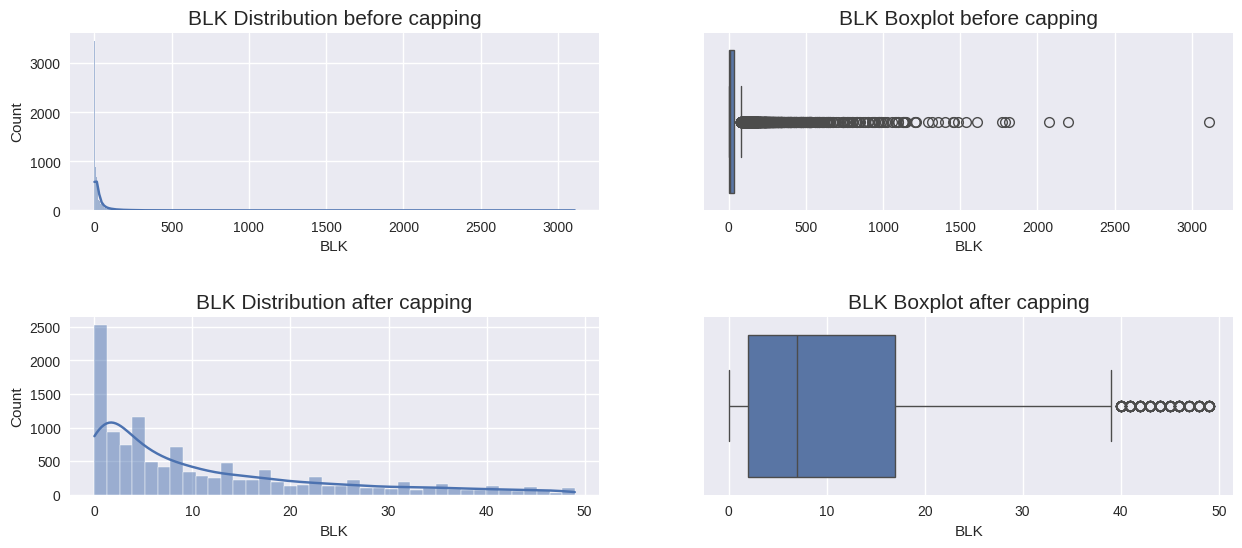

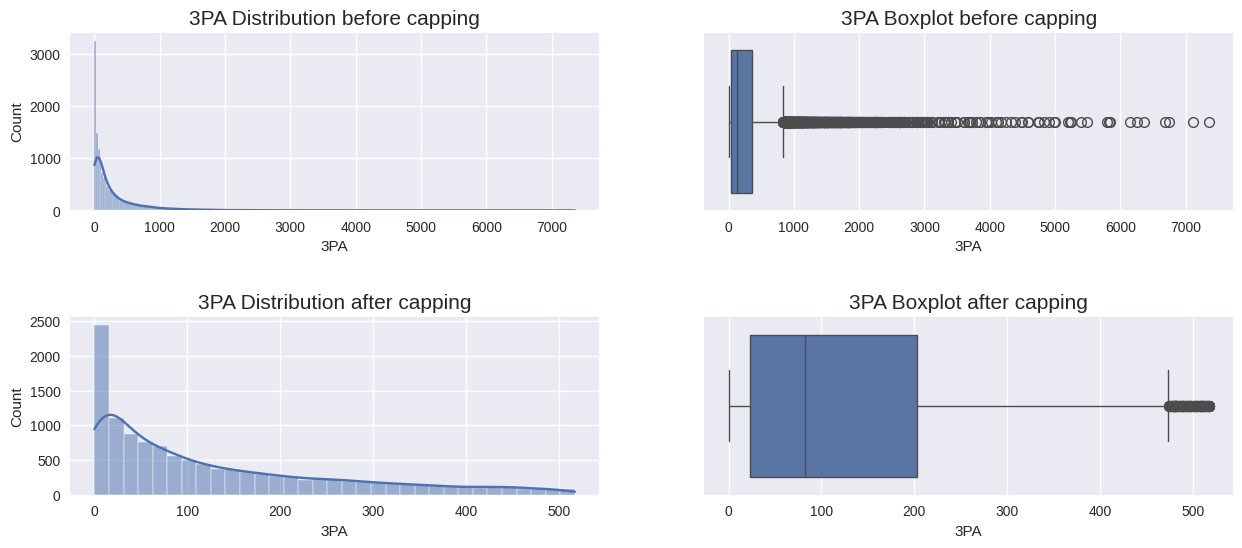

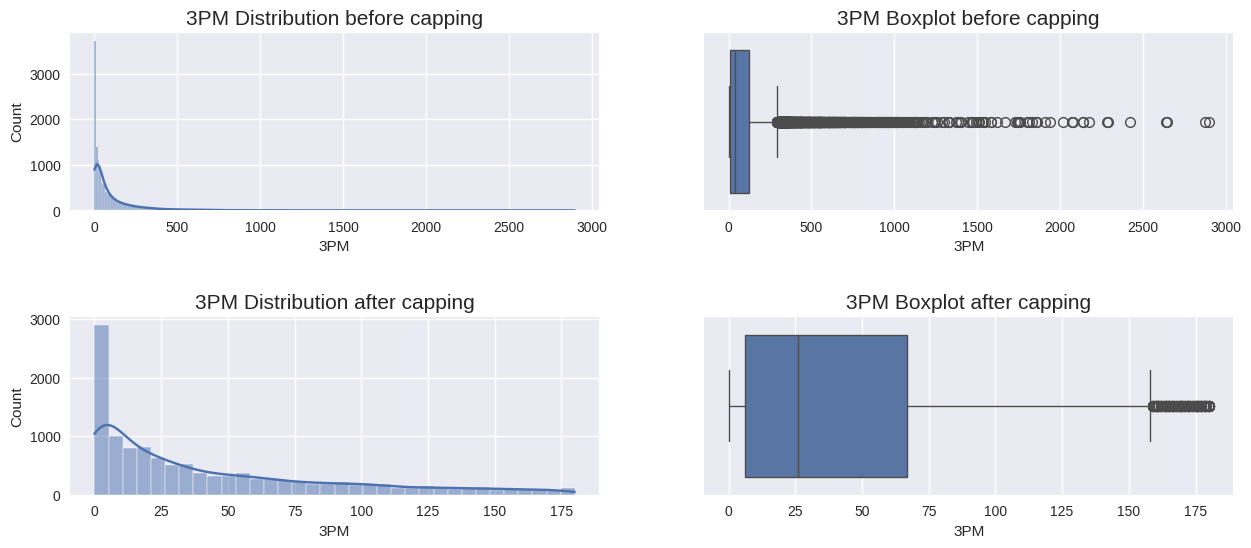

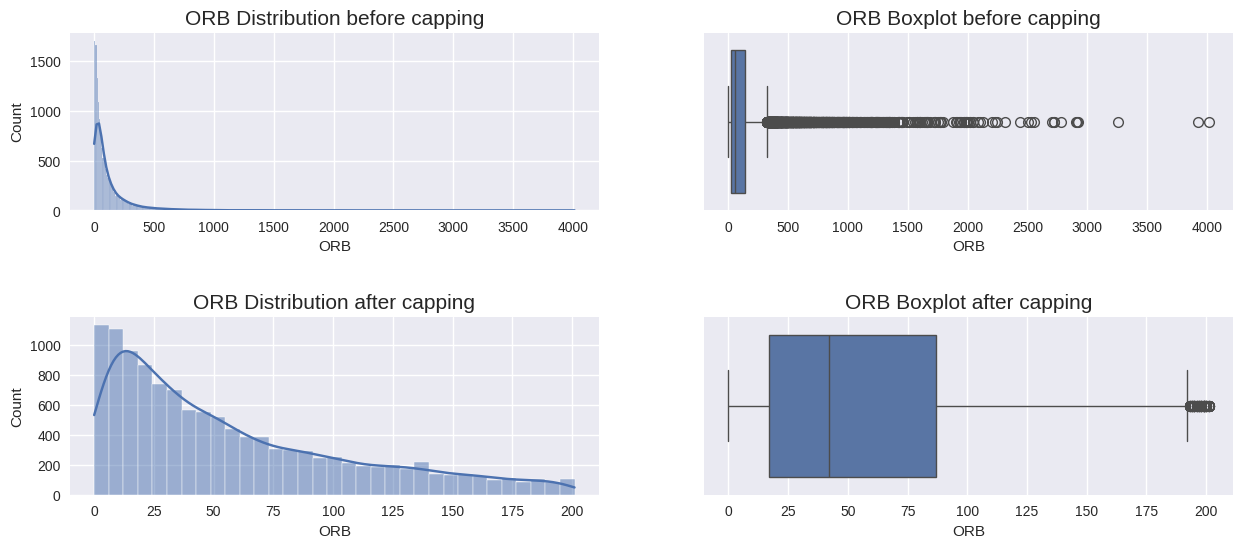

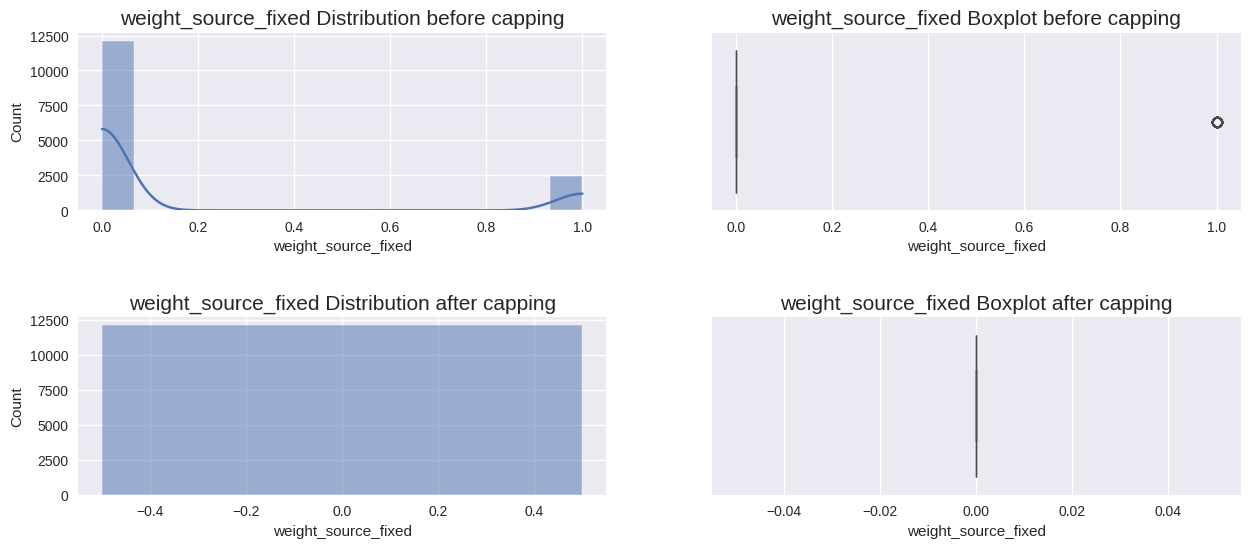

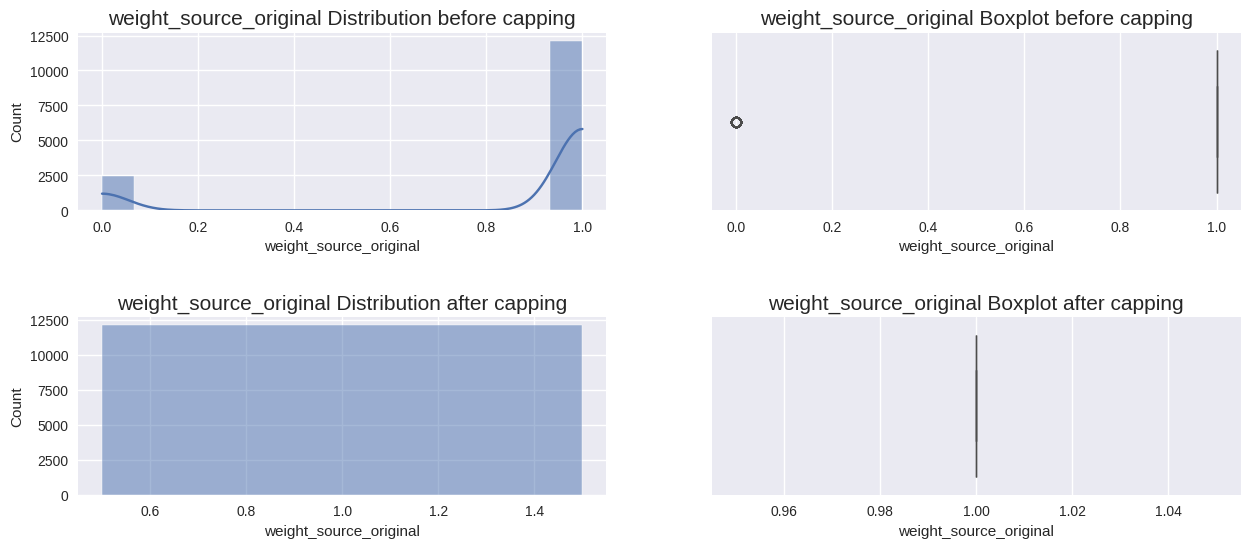

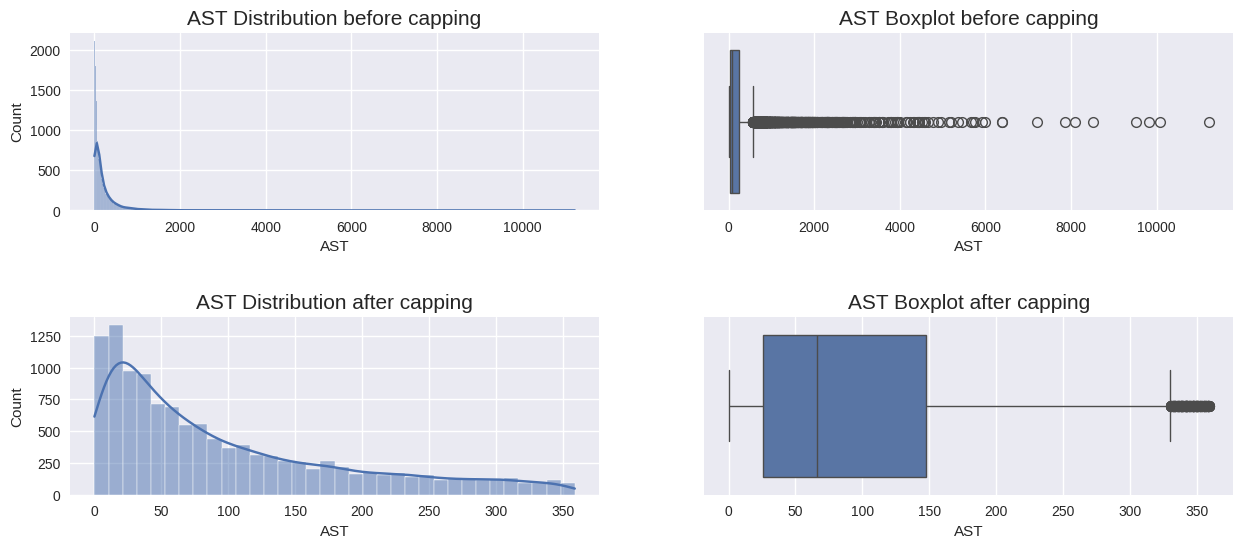

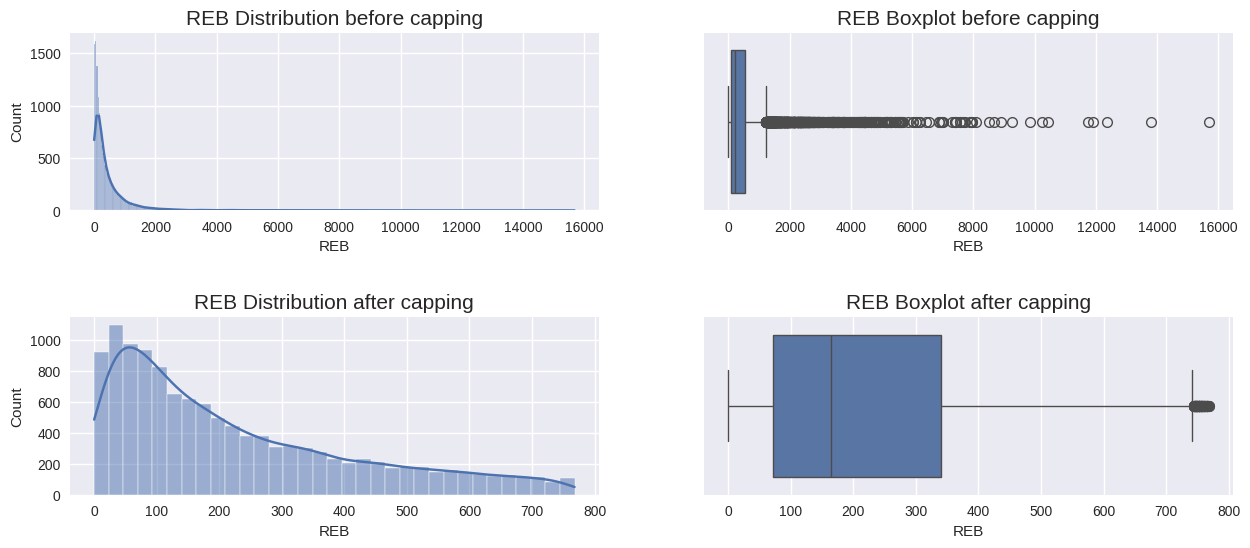

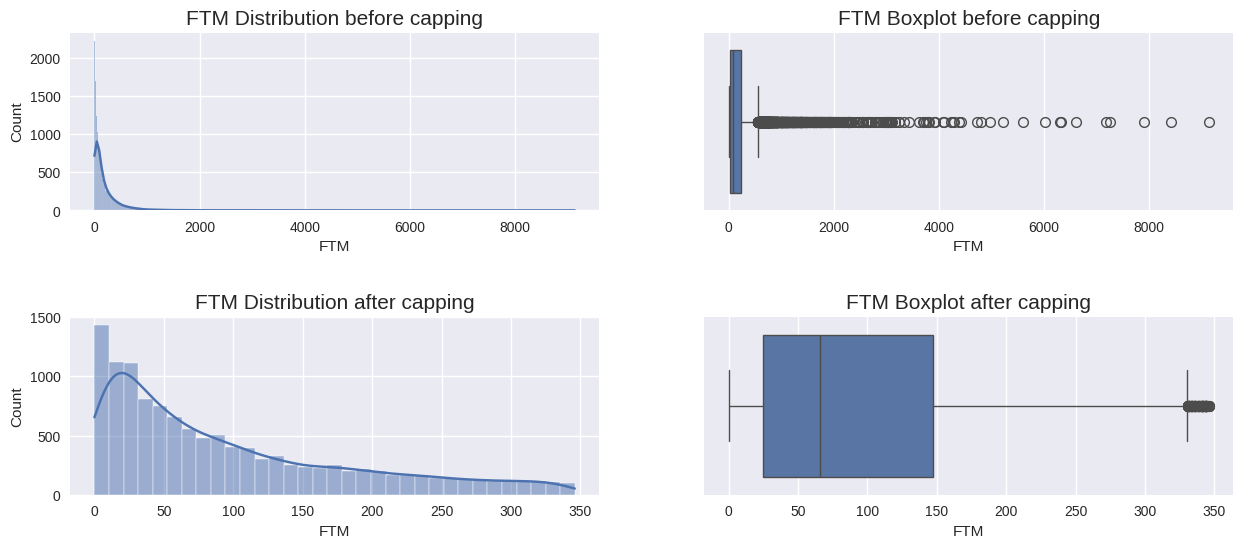

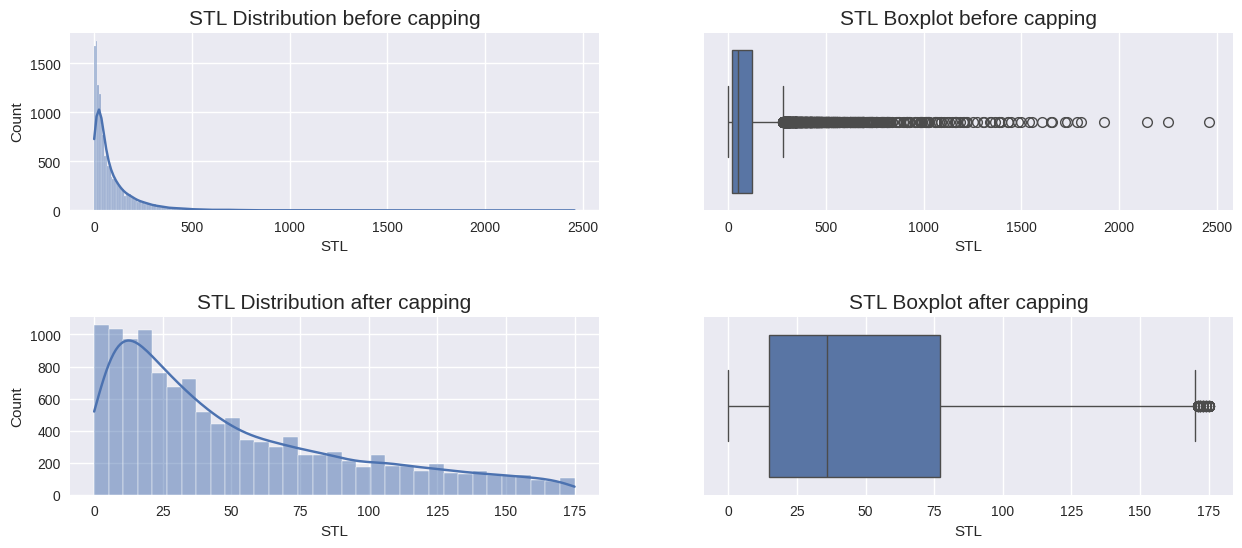

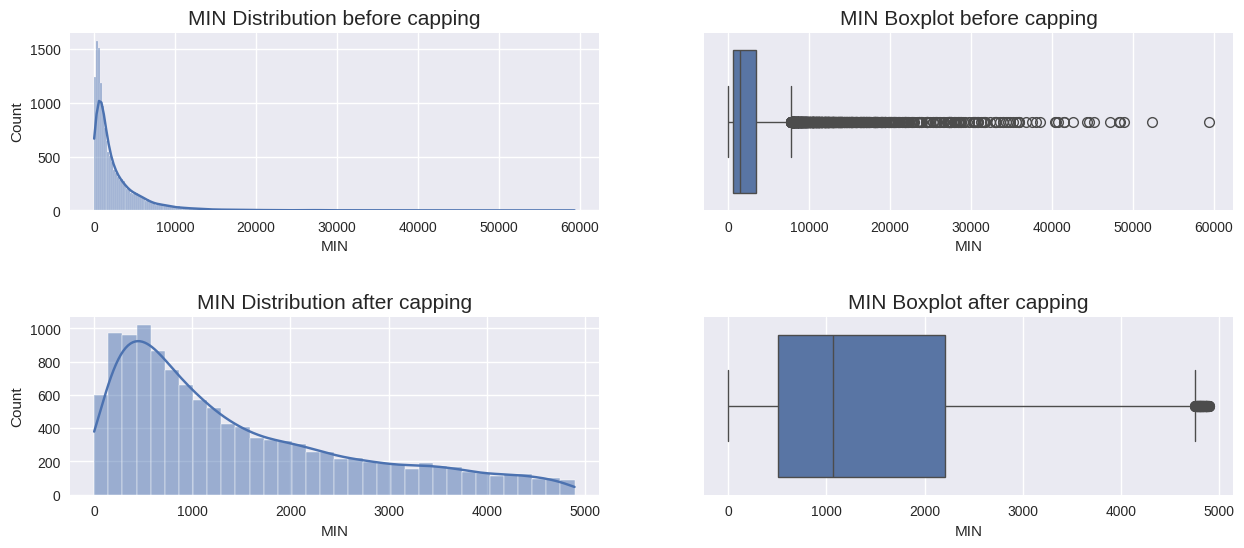

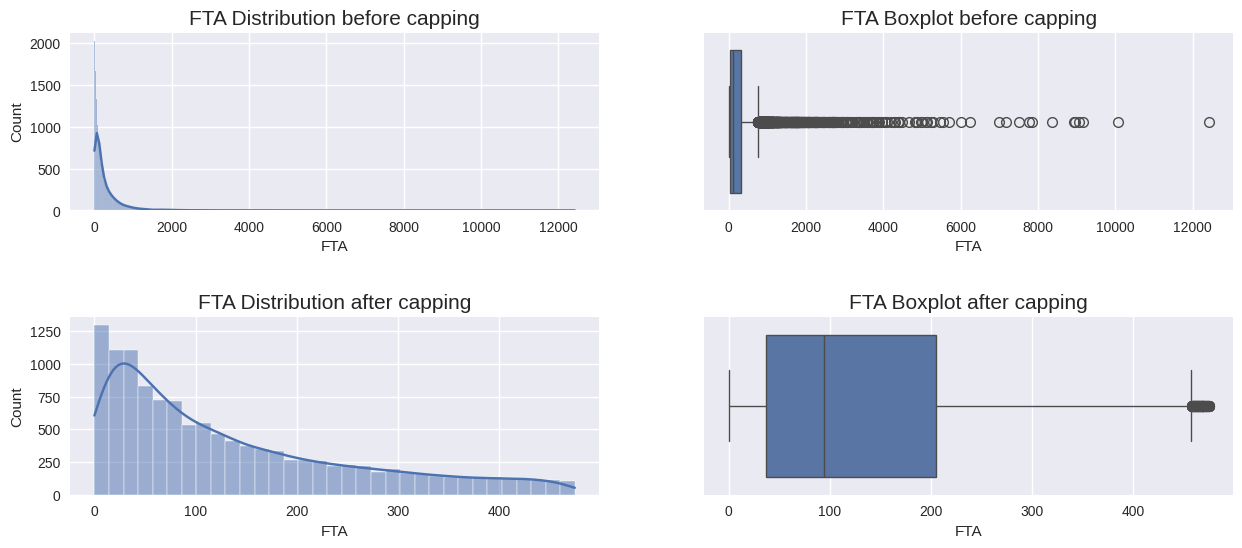

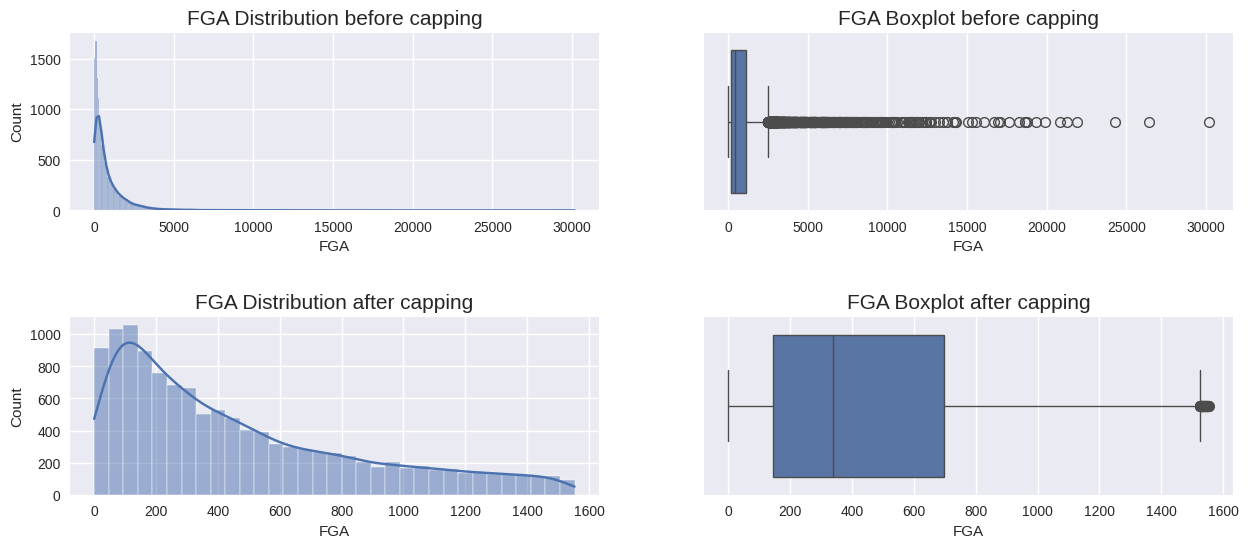

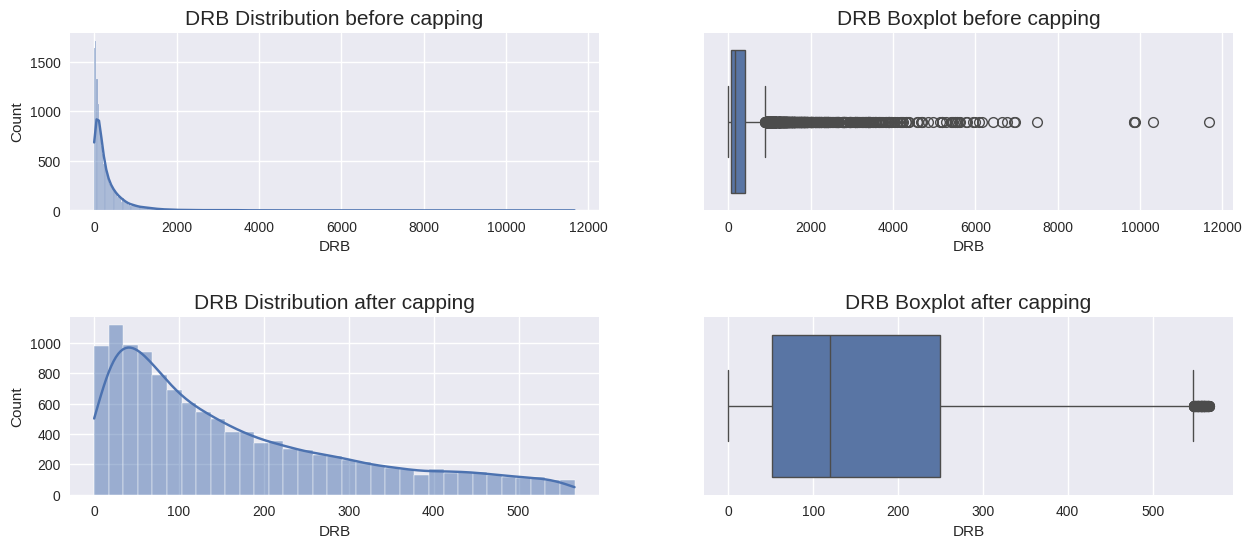

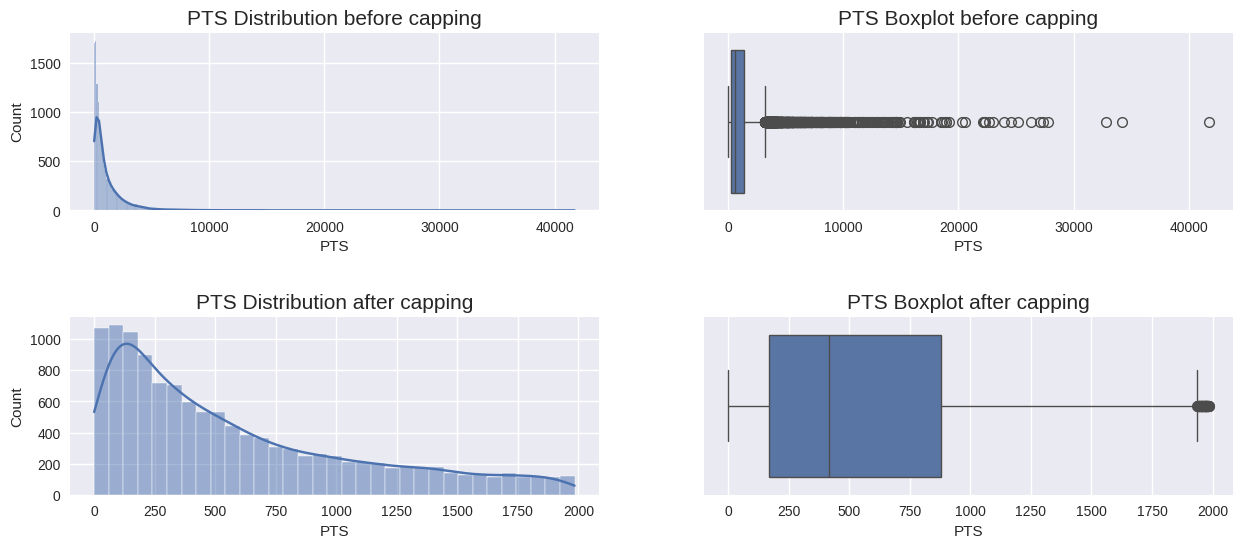

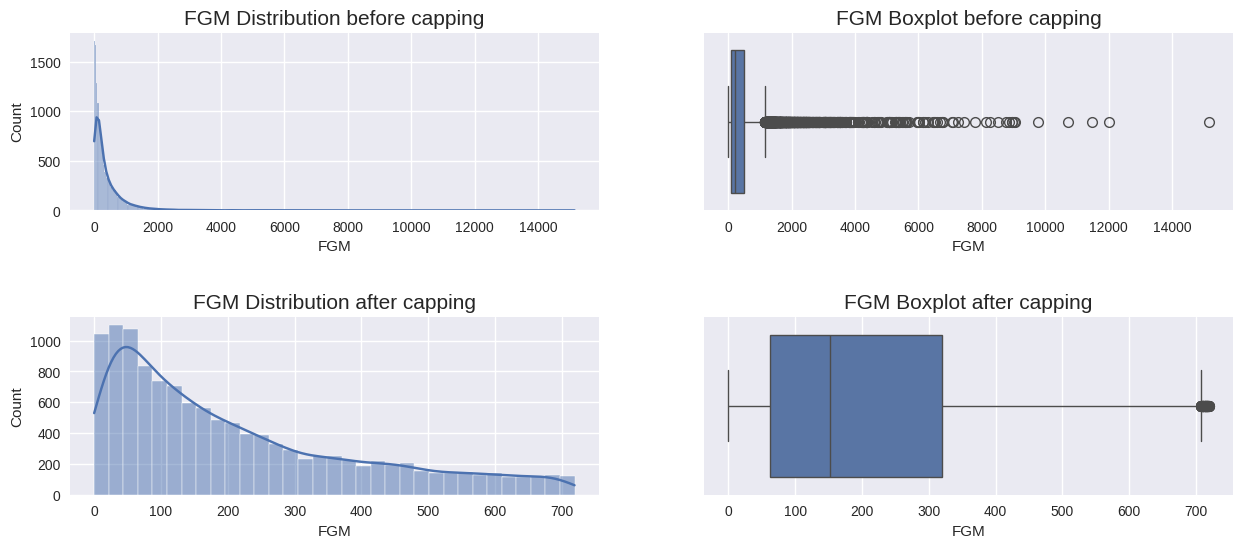

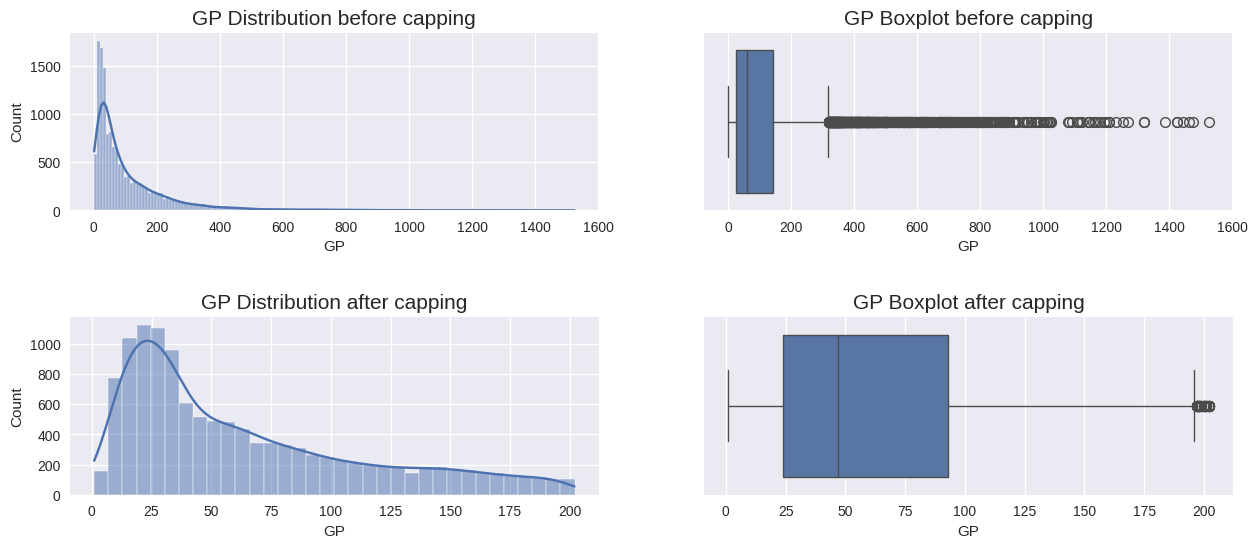

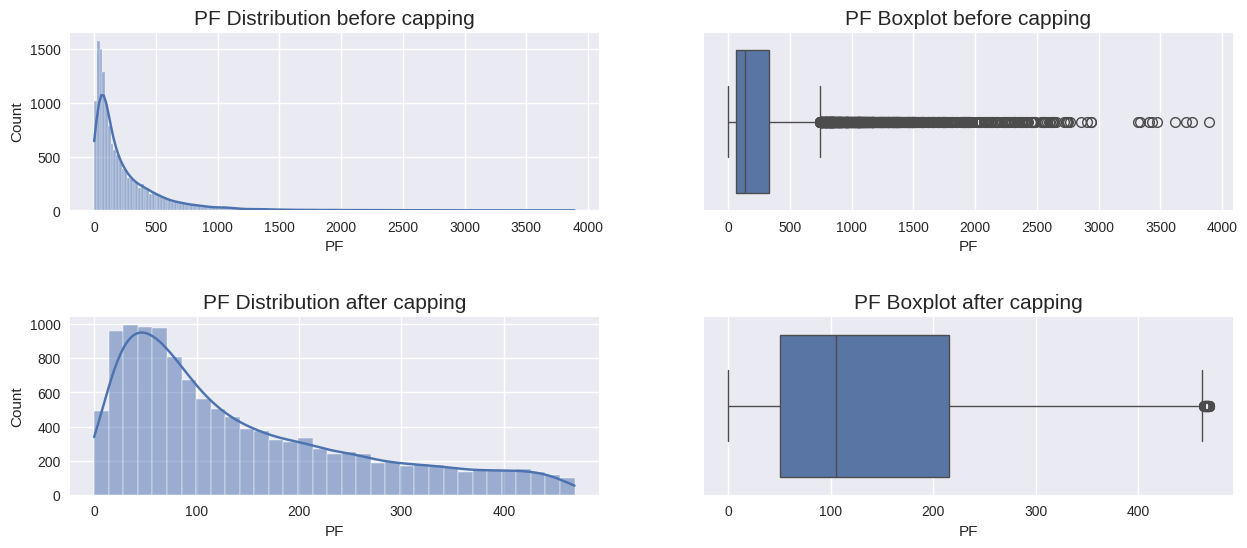

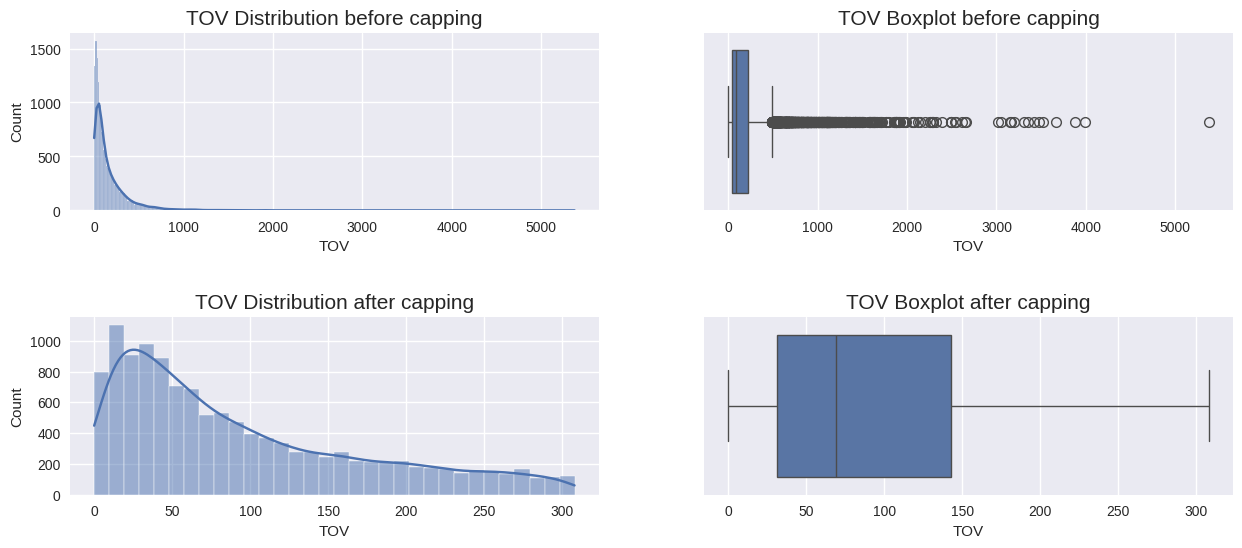

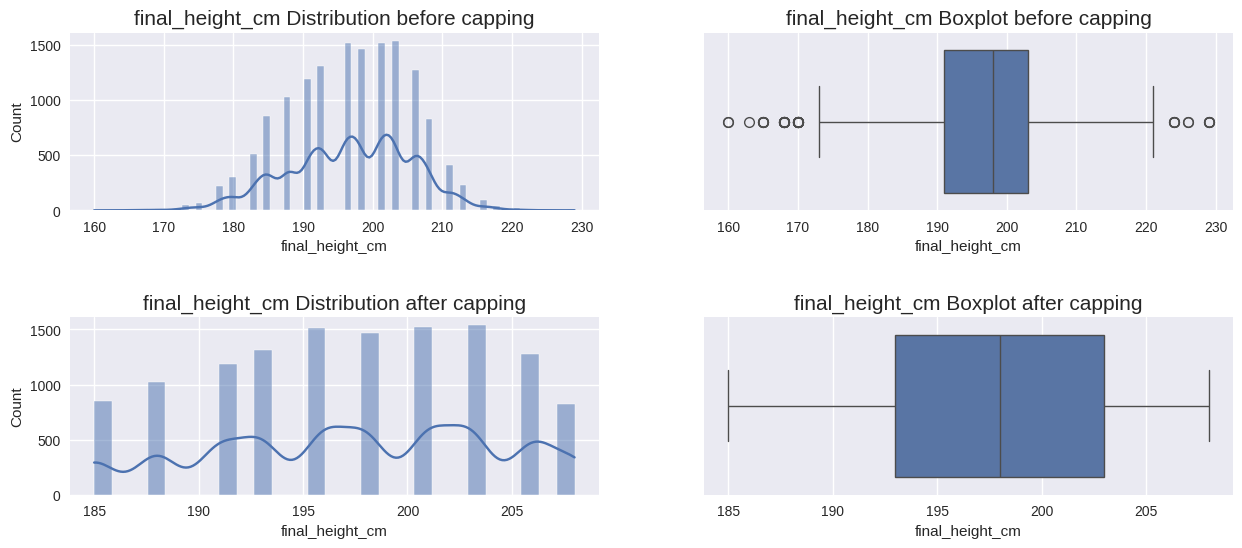

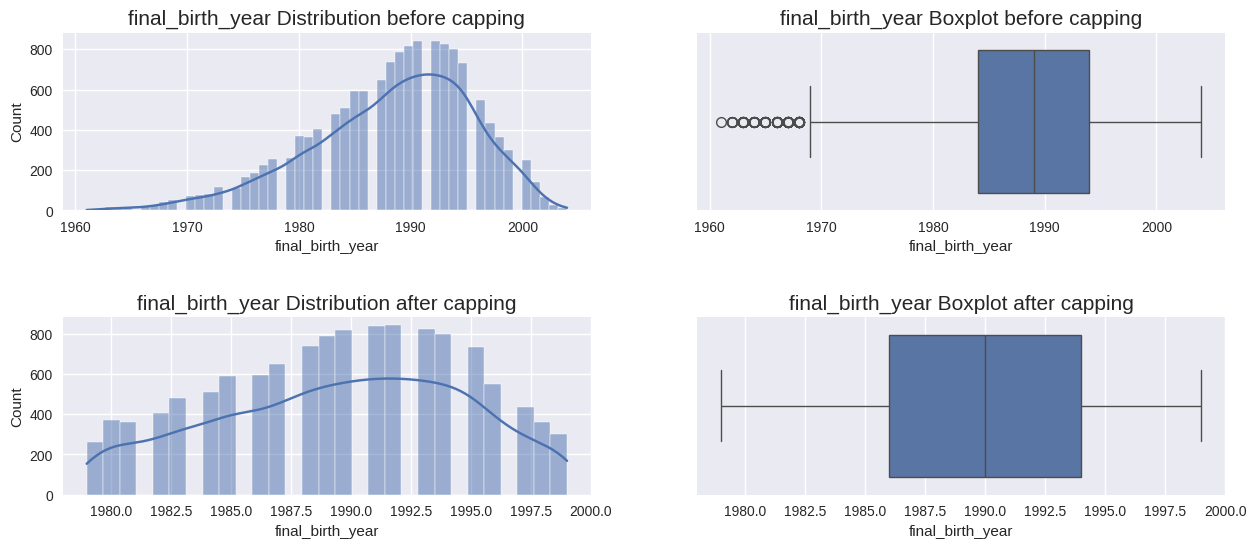

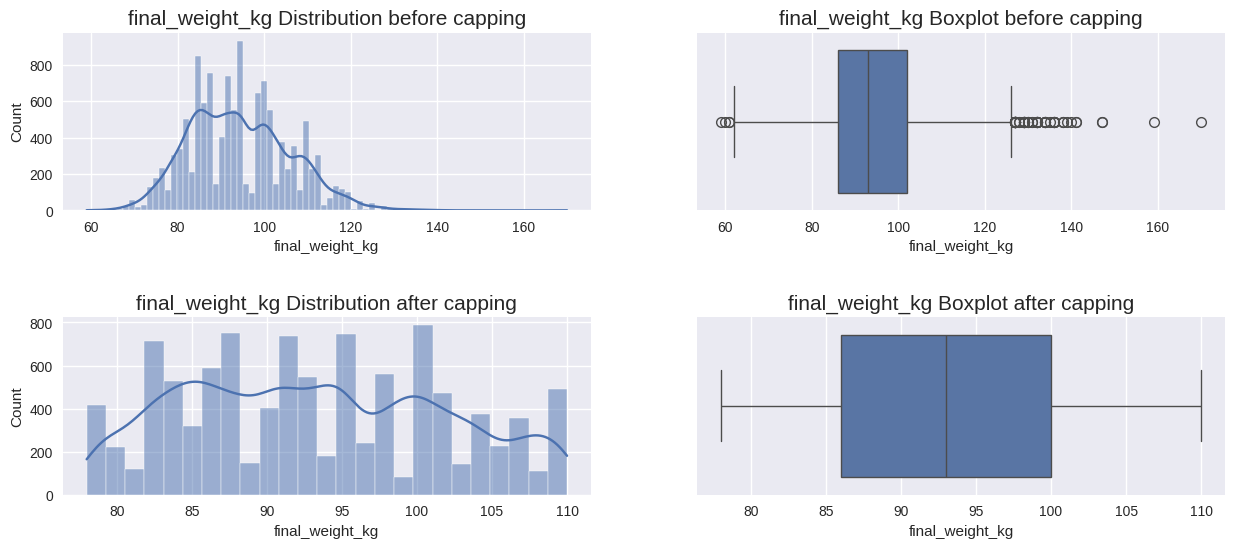

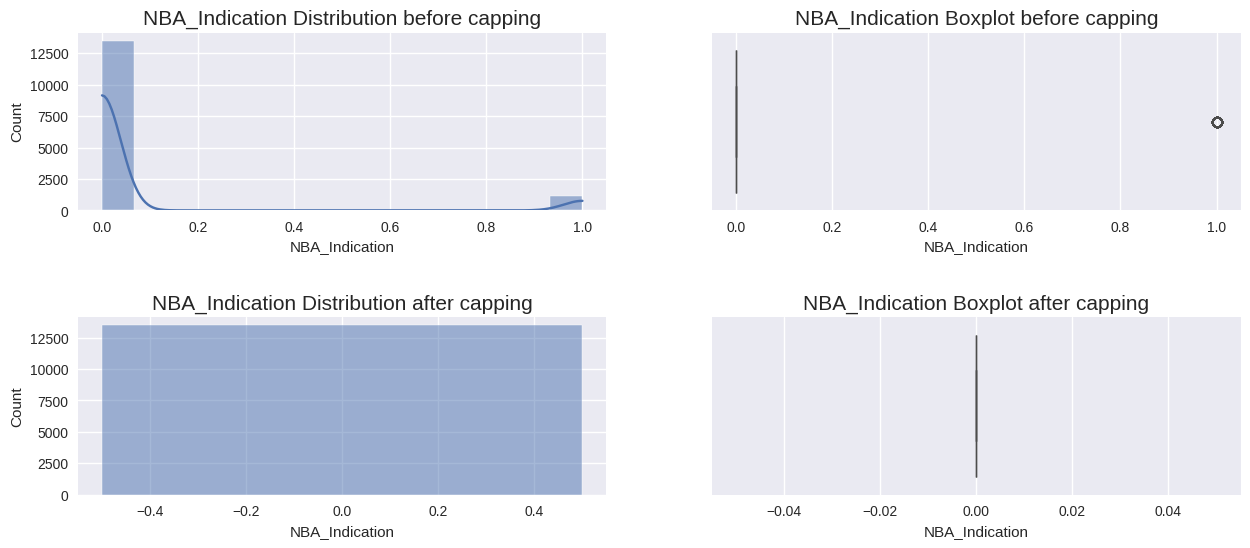

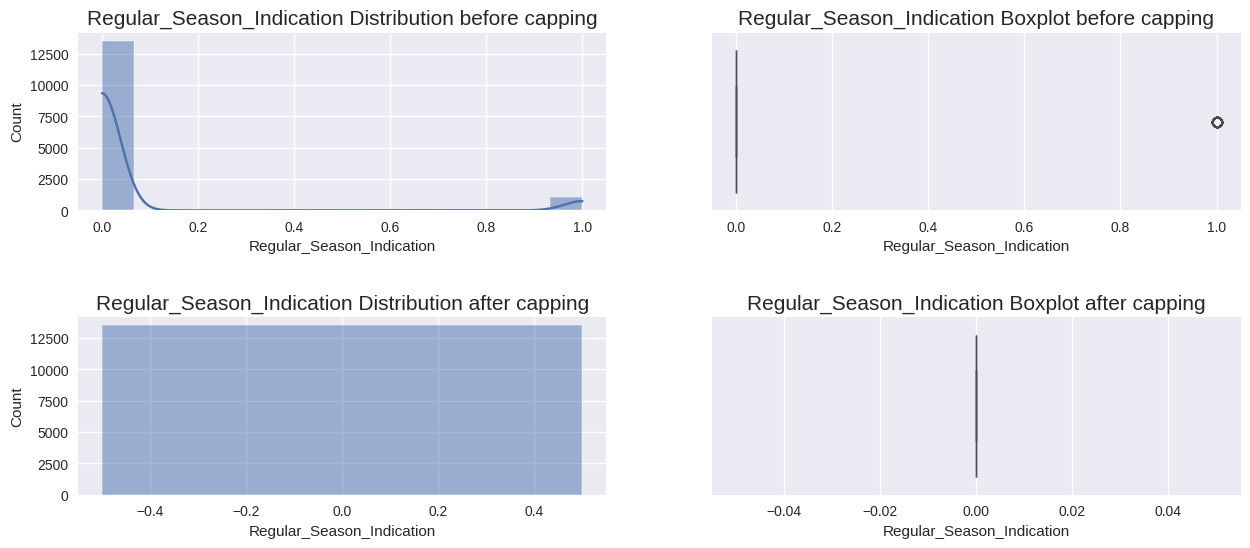

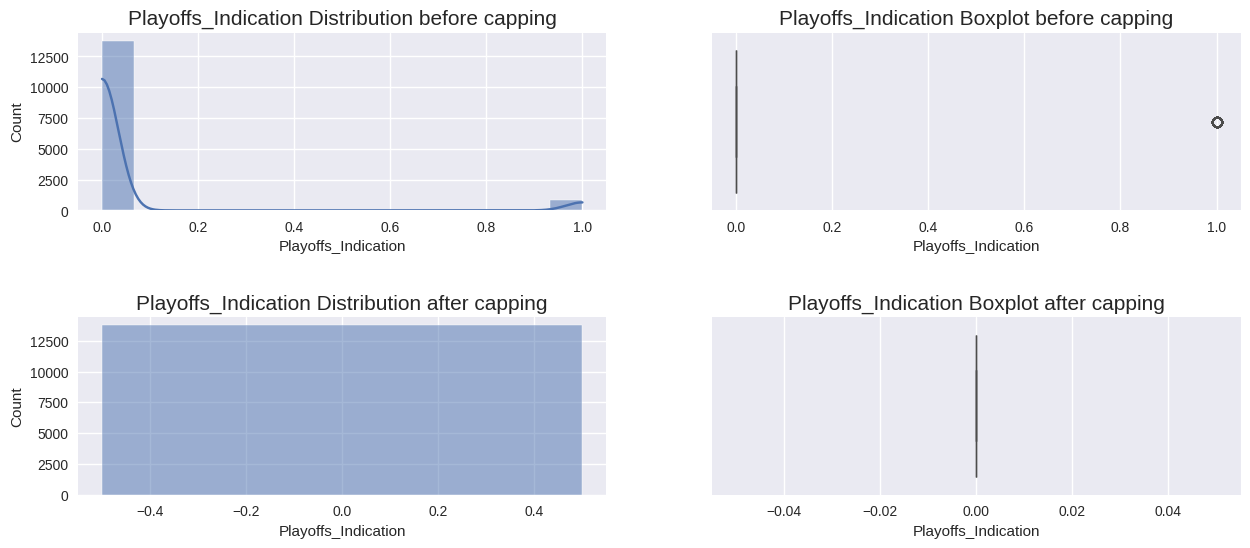

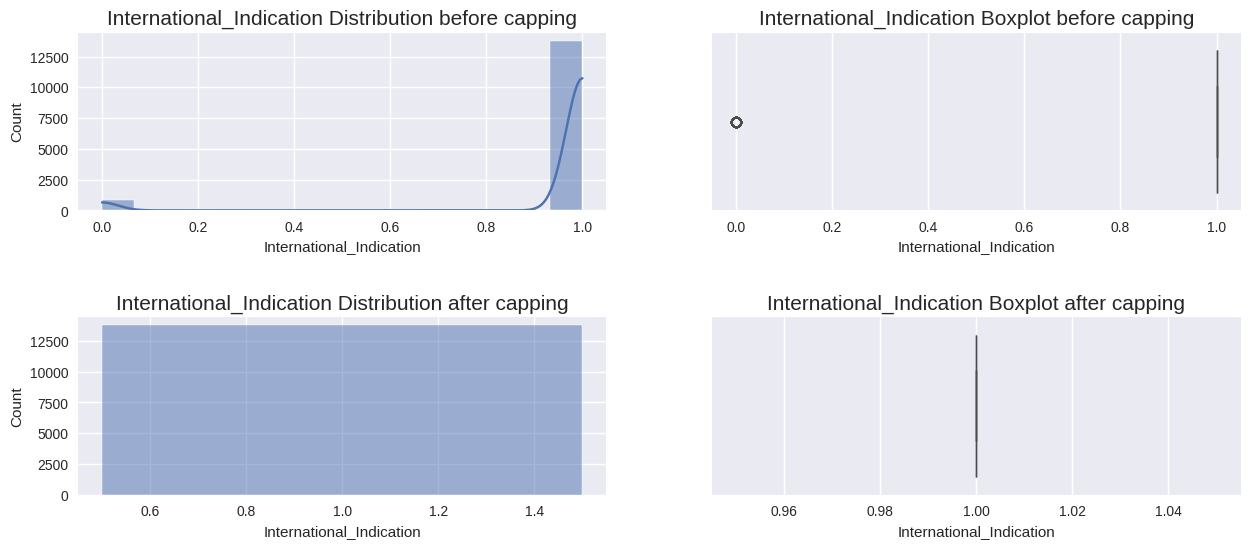

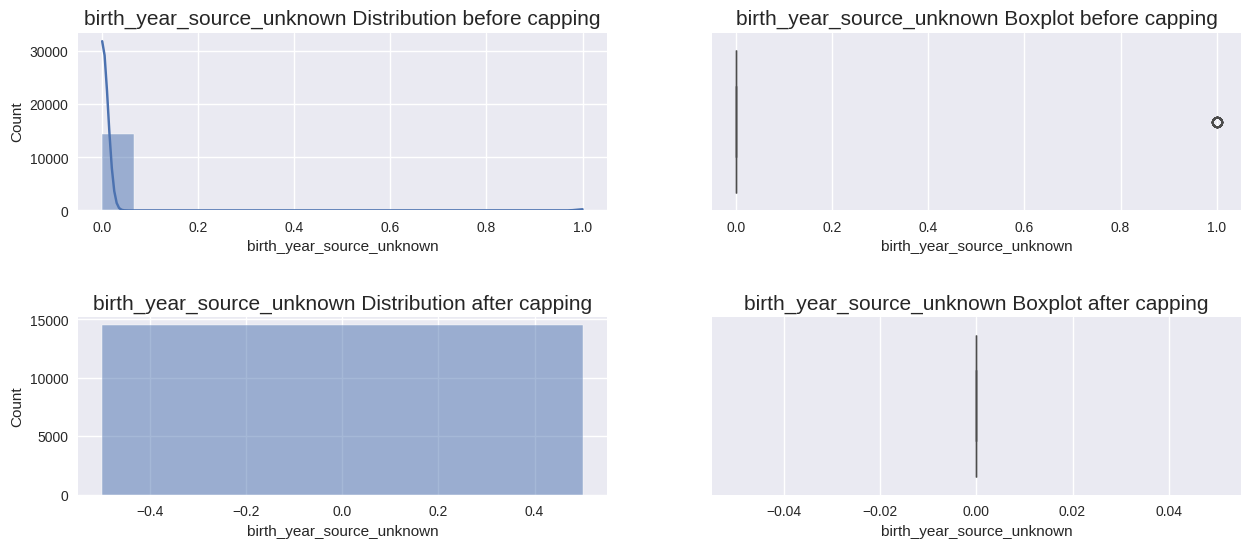

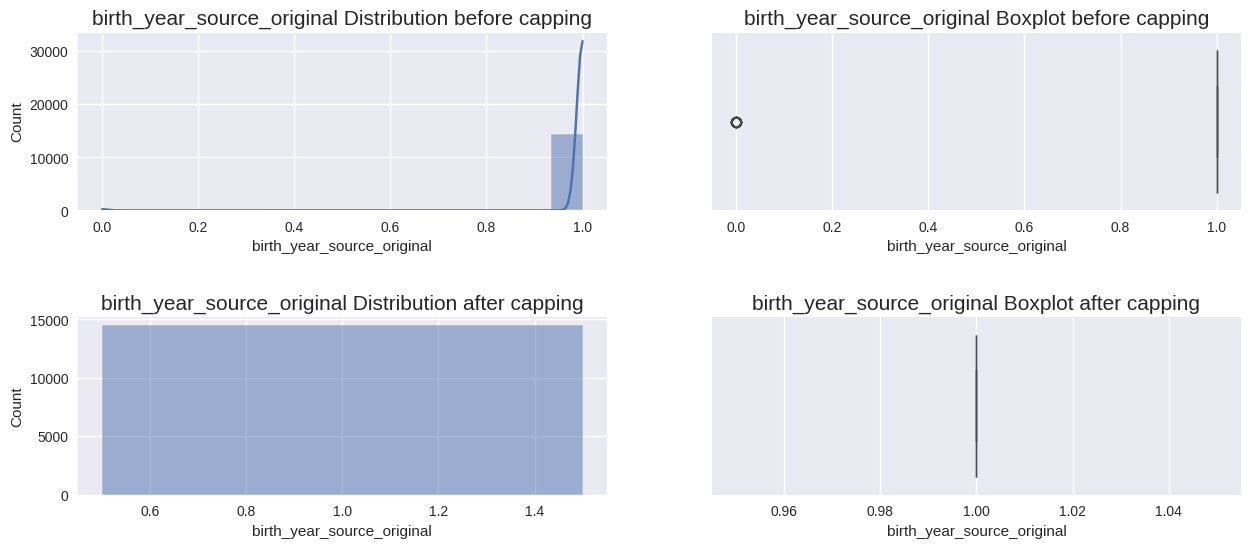

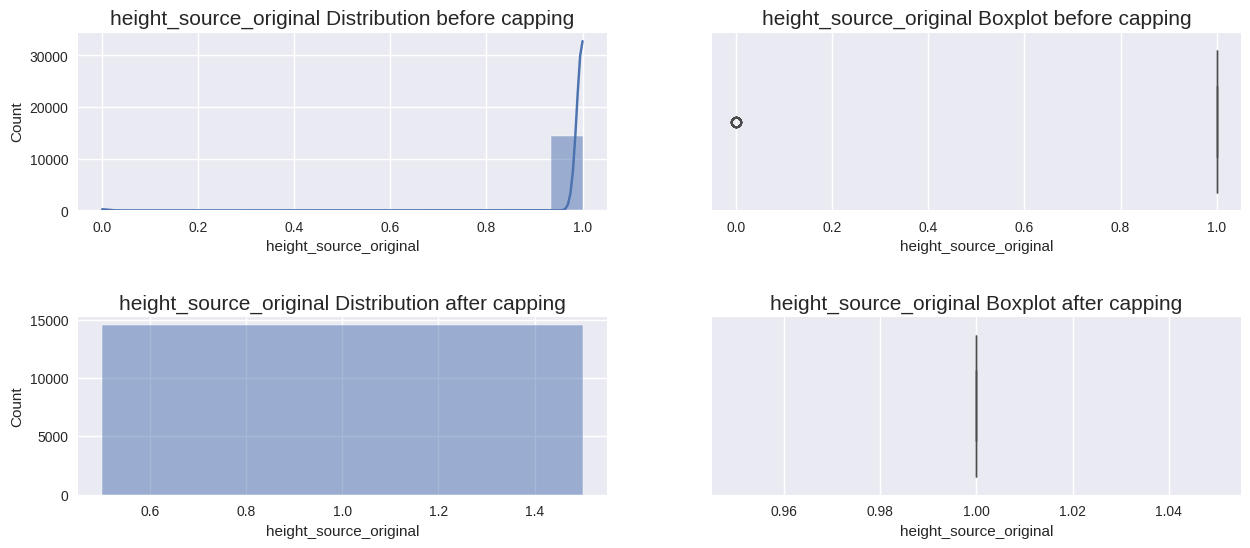

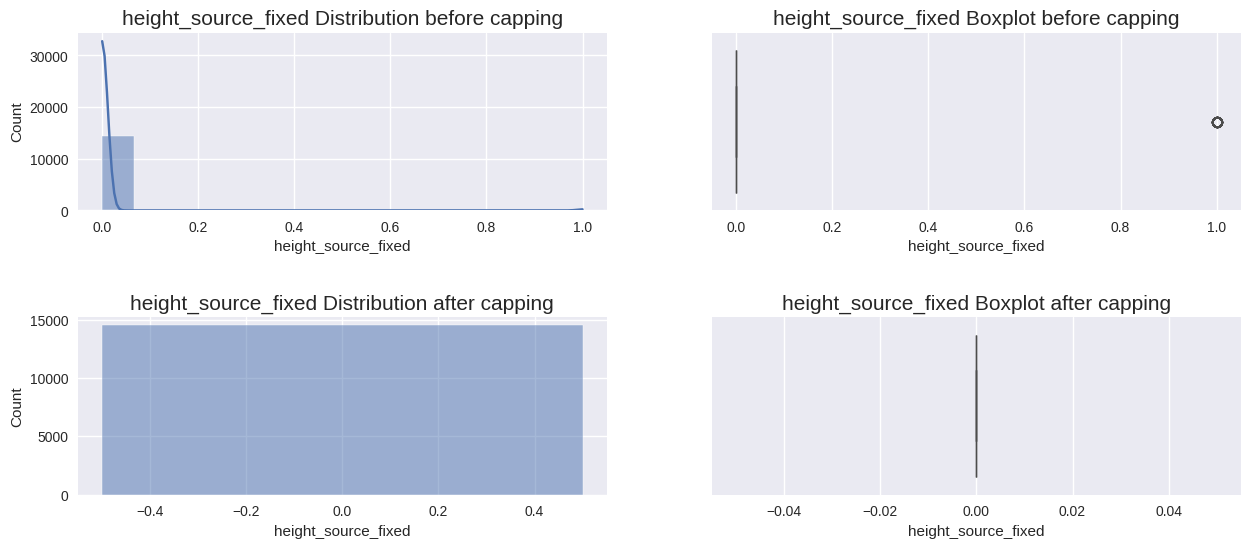

In [ ]:
def dist_outliers(original_df, new, cols):
    for col in cols:
        if col in original_df.columns and col in new.columns:
            plt.figure(figsize=(15,6))

            plt.subplot(2,2,1)
            sns.histplot(original_df[col], kde=True)
            plt.title(f'{col} Distribution before capping', fontsize=15)

            plt.subplot(2,2,2)
            sns.boxplot(x=original_df[col])
            plt.title(f'{col} Boxplot before capping', fontsize=15)

            plt.subplot(2,2,3)
            sns.histplot(new[col], kde=True)
            plt.title(f'{col} Distribution after capping', fontsize=15)

            plt.subplot(2,2,4)
            sns.boxplot(x=new[col])
            plt.title(f'{col} Boxplot after capping', fontsize=15)

            plt.subplots_adjust(hspace=0.6)
            plt.show()

dist_outliers(df, temp, outliers_df.index)


We clearly need to filter some features that either the feature distribution has changed significantly, or cases where removing outliers results with only one value.

Checking if distribution (Kolmogorov–Smirnov) and/or correlation has changed significantly:

In [ ]:
### differences between two correlation in Python: https://github.com/psinger/CorrelationStats
### We will only take from the code the Fisher method for two-tailed test
import numpy as np
from scipy.stats import norm

def cocor(x1, y1, x2, y2):
    # Calculate Spearman correlation for both pairs
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')

    # Get the number of observations in each dataset
    n1 = len(x1)
    n2 = len(x2)

    # Apply Fisher's Z-transformation to the correlations
    xy_z = 0.5 * np.log((1 + xy1) / (1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2) / (1 - xy2))

    # If n2 is None (which shouldn't happen), set it equal to n1
    if n2 is None:
        n2 = n1

    # Calculate the standard error of the difference between Z scores
    se_diff_r = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))

    # Compute the difference between the two Z scores and get the absolute Z value
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)

    # Calculate the two-tailed p-value using the normal distribution CDF
    p = (1 - norm.cdf(z)) * 2

    return z, p

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming df, df_outliers, and the function cocor have been defined earlier

# Select only numerical columns
names = df.select_dtypes(include=[np.number]).columns

# List to store results before creating the DataFrame
outlier_results = []

# Create a copy of the numeric DataFrame without outliers for further operations if needed
no_outliers = df[names].copy()

# Ignore warnings for division or invalid operations
np.seterr(divide='ignore', invalid='ignore')

for i in names:
    # Data with outliers
    out = df[i]

    # Data without outliers
    non = df[i].loc[df_outliers[i] == 0]

    # Label with outliers
    nba_out = df['NBA_Indication']

    # Label without outliers
    nba_non = df['NBA_Indication'].loc[df_outliers[i] == 0]

    # Compute correlation p-value using the cocor function
    # Note: cocor returns (z, p-value)
    z, pvalue = cocor(out, nba_out, non, nba_non)
    cor_change = np.where(pvalue < 0.05, '+', '-')

    # Count of outliers (summing over the entire column)
    mv = df_outliers[i].sum()  # Adjusted to sum for the specific column 'i'

    # KS-test p-value to check if the distribution has changed significantly
    pval = ks_2samp(out, non)[1]
    dist_change = np.where(pval < 0.05, '+', '-')

    # Append results for this feature to the list
    outlier_results.append({
        'feature': i,
        'outliers_cnt': mv,
        'distribution_changed': dist_change,
        'correlation_changed': cor_change
    })

# Convert the list of results to a DataFrame with selected columns
out_df = pd.DataFrame(outlier_results, columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

# Display the first few rows of the results DataFrame
print(out_df.head())


  feature  outliers_cnt distribution_changed correlation_changed
0      GP          2326                    +                   +
1     MIN          2408                    +                   +
2     FGM          2361                    +                   +
3     FGA          2384                    +                   +
4     3PM          2548                    +                   +


In [ ]:
#All 'Yes' Vars in the 'Drop'colums shall be deleted, since the infect correlation and distribution.
#We don't want to delete vars that will change the distribution
out_df['drop']='yes'
out_df.loc[(out_df.distribution_changed=='+')& (out_df.correlation_changed=='+'),'drop'] = 'no'
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,GP,2326,+,+,no
1,MIN,2408,+,+,no
2,FGM,2361,+,+,no
3,FGA,2384,+,+,no
4,3PM,2548,+,+,no
5,3PA,2566,+,+,no
6,FTM,2433,+,+,no
7,FTA,2407,+,+,no
8,TOV,2319,+,+,no
9,PF,2325,+,+,no


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from scipy.stats import norm

# Filter only numeric columns that are not dummies
# We assume that dummy columns only contain values 0 and 1 (or a subset thereof)
all_numeric = df.select_dtypes(include=[np.number]).columns
names = [col for col in all_numeric if not set(df[col].dropna().unique()).issubset({0, 1})]

# List to store results before creating the DataFrame
outlier_results = []

# Create a copy of the numeric DataFrame (non-dummy columns)
no_outliers = df[names].copy()
np.seterr(divide='ignore', invalid='ignore')

for i in names:
    # Data with outliers
    out = df[i]

    # Data without outliers
    non = df[i].loc[df_outliers[i] == 0]

    # Label with outliers (assuming NBA_Indication is still relevant)
    nba_out = df['NBA_Indication']

    # Label without outliers
    nba_non = df['NBA_Indication'].loc[df_outliers[i] == 0]

    # Compute correlation p-value using the cocor function
    z, pvalue = cocor(out, nba_out, non, nba_non)
    cor_change = np.where(pvalue < 0.05, '+', '-')

    # Count of outliers for the current column
    mv = df_outliers[i].sum()  # sum for column i

    # KS-test p-value to check if distribution changed significantly
    pval = ks_2samp(out, non)[1]
    dist_change = np.where(pval < 0.05, '+', '-')

    # Append results for this feature to the list
    outlier_results.append({
        'feature': i,
        'outliers_cnt': mv,
        'distribution_changed': dist_change,
        'correlation_changed': cor_change
    })

# Convert the list of results to a DataFrame with selected columns
out_df = pd.DataFrame(outlier_results, columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

# Mark columns for deletion: default 'yes'
out_df['drop'] = 'yes'
# If both distribution and correlation have changed, do not drop (set to 'no')
out_df.loc[(out_df.distribution_changed == '+') & (out_df.correlation_changed == '+'), 'drop'] = 'no'

# Ensure specific columns are not dropped regardless
excluded_columns = ["Number_of_Leagues_Played", "NBA_Indication", "Number_of_Stages_Played",
                    "International indication", "Regular_Season indication", "Playoffs indication"]
out_df.loc[out_df['feature'].isin(excluded_columns), 'drop'] = 'no'

# Display the first 35 rows of the results DataFrame
print(out_df.head(35))



             feature  outliers_cnt distribution_changed correlation_changed  \
0                 GP          2326                    +                   +   
1                MIN          2408                    +                   +   
2                FGM          2361                    +                   +   
3                FGA          2384                    +                   +   
4                3PM          2548                    +                   +   
5                3PA          2566                    +                   +   
6                FTM          2433                    +                   +   
7                FTA          2407                    +                   +   
8                TOV          2319                    +                   +   
9                 PF          2325                    +                   +   
10               ORB          2522                    +                   +   
11               DRB          2381                  

In [ ]:
out_df.groupby('drop').size()

,0
drop,
no,17
yes,3


There are 17 features in total where removal of the outliers does not affect neither correlation nor distribution. And 3 features that shall be removed.



In [ ]:
relevant_columns_features=out_df.loc[out_df['drop']=='yes']['feature']
relevant_columns_features

,feature
17,final_birth_year
18,final_height_cm
19,final_weight_kg


Let's see the distribution with and without outliers for does specific 3 features:

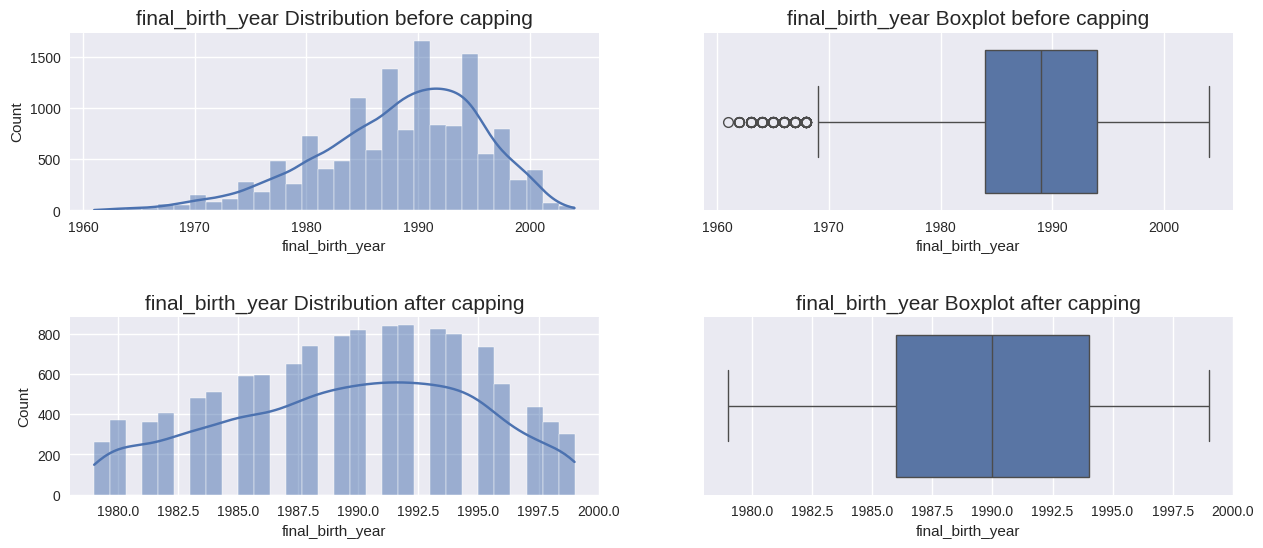

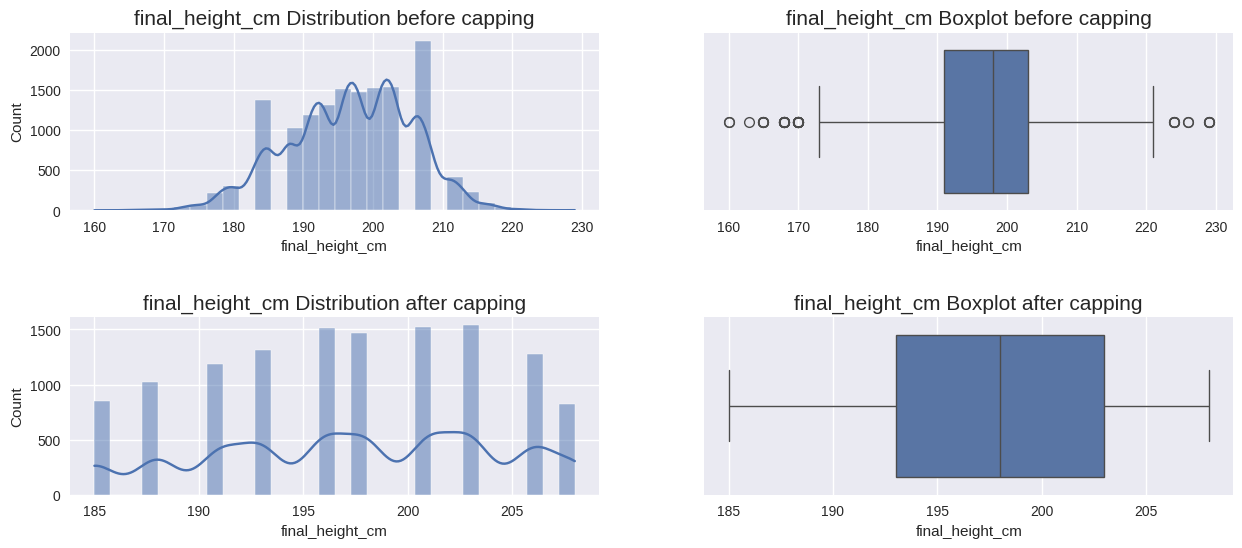

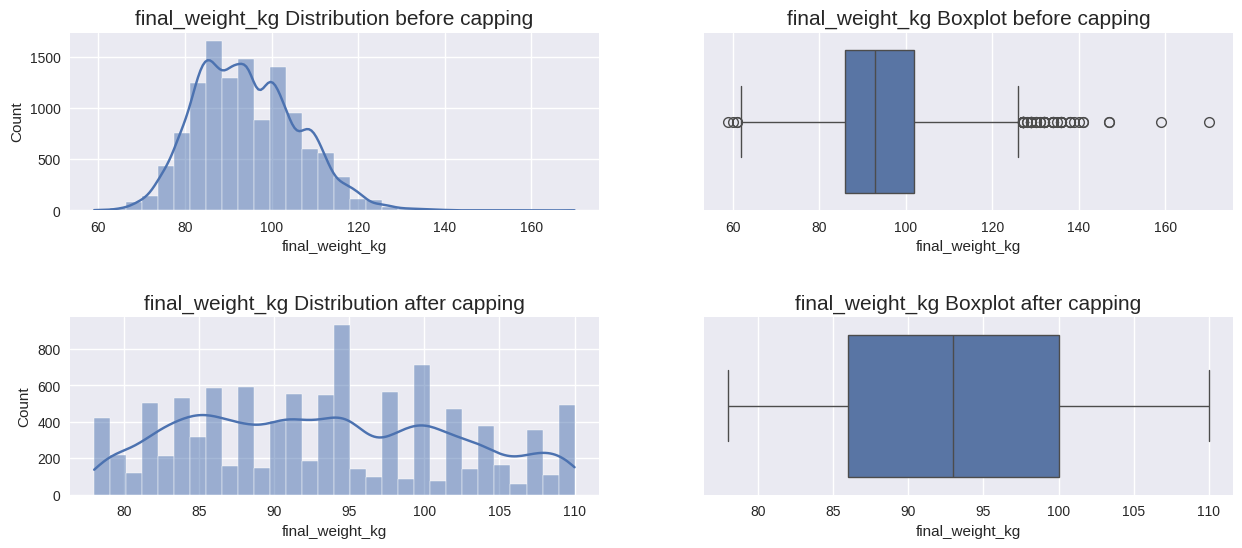

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def dist_compare_after_capping(original_df, new_df, relevant_cols):
    for col in relevant_cols:
        if col in original_df.columns:
            plt.figure(figsize=(15, 6))

            # Distribution before capping: Histogram with KDE
            plt.subplot(2, 2, 1)
            sns.histplot(original_df[col], kde=True, bins=30)
            plt.title(f'{col} Distribution before capping', fontsize=15)

            # Boxplot before capping
            plt.subplot(2, 2, 2)
            sns.boxplot(x=original_df[col])
            plt.title(f'{col} Boxplot before capping', fontsize=15)

            # Distribution after capping: Histogram with KDE
            plt.subplot(2, 2, 3)
            sns.histplot(new_df[col], kde=True, bins=30)
            plt.title(f'{col} Distribution after capping', fontsize=15)

            # Boxplot after capping
            plt.subplot(2, 2, 4)
            sns.boxplot(x=new_df[col])
            plt.title(f'{col} Boxplot after capping', fontsize=15)

            plt.subplots_adjust(hspace=0.6)
            plt.show()

# Call the function with original DataFrame, DataFrame after capping, and the relevant columns
dist_compare_after_capping(df, temp, relevant_columns_features)



After careful consideration, we have decided to address all columns with outliers. This approach ensures that we retain a sufficient amount of original data while effectively handling anomalies.

In [ ]:
print(relevant_columns_features)

17    final_birth_year
18     final_height_cm
19     final_weight_kg
Name: feature, dtype: object


In [ ]:
remove_outliers = ['final_birth_year','final_height_cm','final_weight_kg']
remove_outliers

['final_birth_year', 'final_height_cm', 'final_weight_kg']

Removing outleirs that don't change correlation

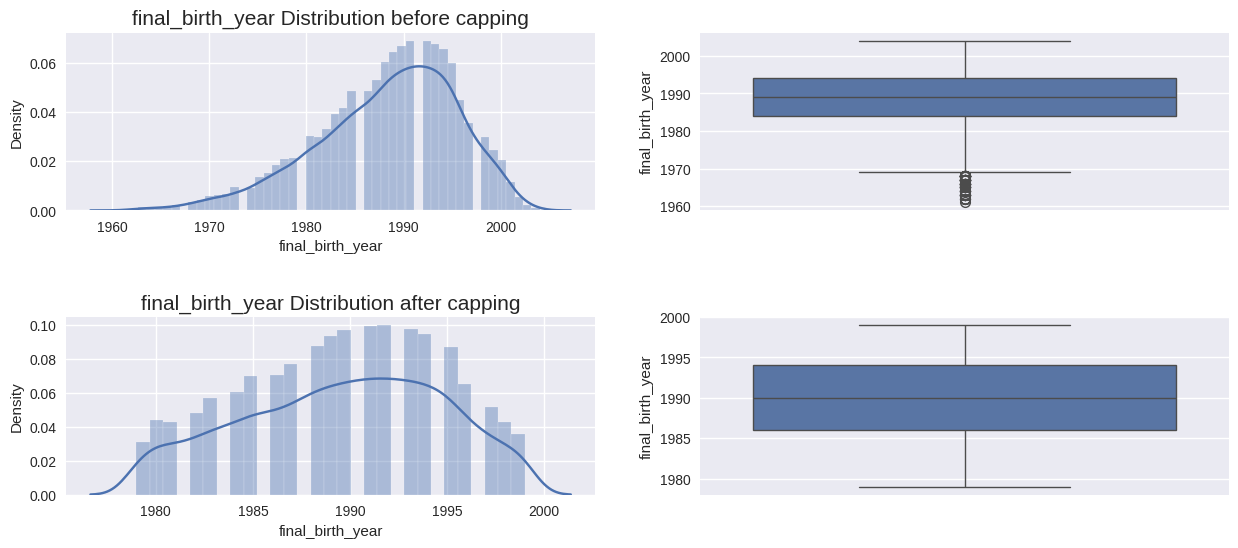

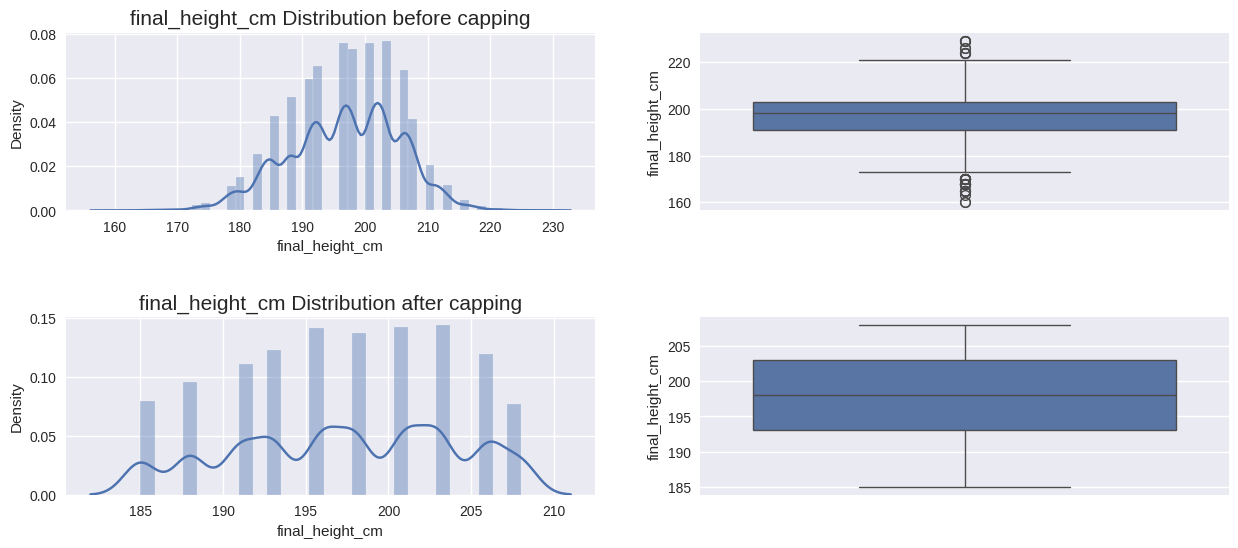

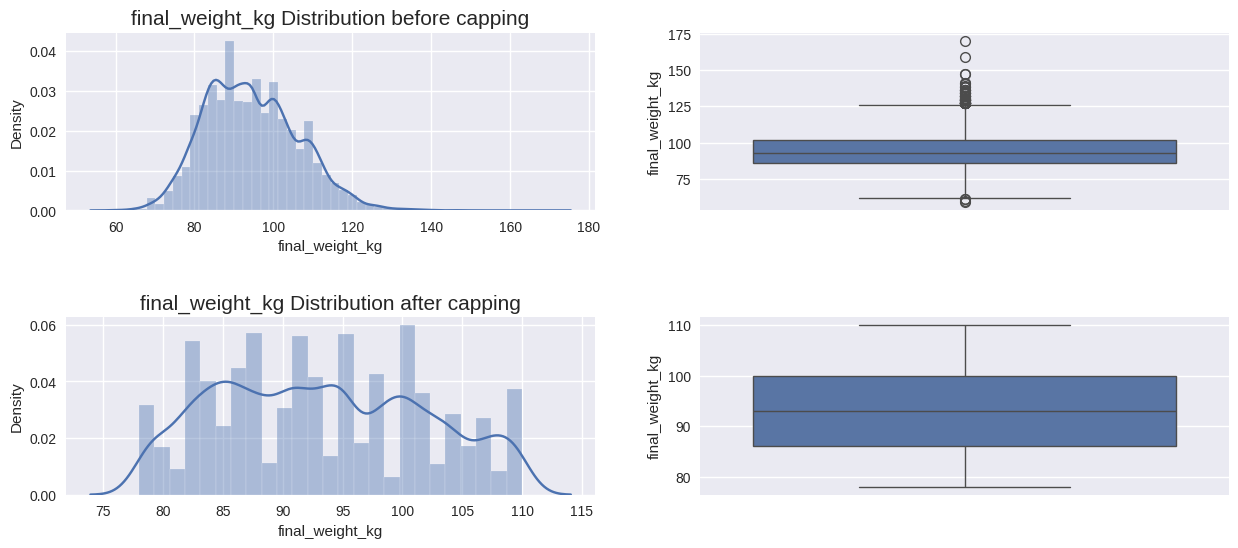

In [ ]:
def dist_compare_after_capping(original_df, new, cols):
    for col in relevant_columns_features:
        if col in cols:
            plt.figure(figsize=(15,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col])
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(new[col])
            plt.show()
dist_compare_after_capping(df, temp, outliers_df.index)

In [ ]:
print(df_outliers.head())  # View the first few rows
print(df_outliers.dtypes)  # Data types of each column
print(df_outliers.sum())   # Count of outliers in each column




   Player  GP  MIN  FGM  FGA  3PM  3PA  FTM  FTA  TOV  ...  \
0       0   0    0    0    0    0    0    0    0    0  ...   
1       0   0    0    0    0    0    0    0    0    0  ...   
2       0   0    0    0    0    0    0    0    0    0  ...   
3       0   0    0    0    0    0    0    0    0    0  ...   
4       0   0    0    0    0    0    0    0    0    0  ...   

   Playoffs_Indication  final_birth_year  final_height_cm  final_weight_kg  \
0                    0                 0                0                0   
1                    0                 0                0                0   
2                    1                 1                0                0   
3                    0                 0                0                0   
4                    0                 1                0                0   

   height_source_fixed  height_source_original  birth_year_source_original  \
0                    1                       1                           0   
1 

In [ ]:
print(df_outliers[remove_outliers].sum())  # כמה ערכים חריגים יש בכל אחת מהעמודות שנבחרו


final_birth_year    1969
final_height_cm     1985
final_weight_kg     1854
dtype: int64


In [ ]:
import numpy as np

# Create a copy of the original DataFrame to apply the changes
df_capped = df.copy()

# For each column in remove_outliers, replace the outlier values with np.nan
for col in remove_outliers:
    df_capped.loc[df_outliers[col] == 1, col] = np.nan

# Verify the changes: count how many values were replaced in each column
print(df_capped[remove_outliers].isnull().sum())


final_birth_year    2339
final_height_cm     2053
final_weight_kg     4306
dtype: int64


In [ ]:
# Save the updated dataset (df_capped) to CSV without the index
df_capped.to_csv('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_outliers.csv', index=False)

# Save the updated dataset (df_capped) to a pickle file
df_capped.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_outliers.pkl')

print("Files saved successfully: NBA_after_outliers.csv and NBA_after_outliers.pkl")



Files saved successfully: NBA_after_outliers.csv and NBA_after_outliers.pkl


In [ ]:
import pandas as pd

# Read the CSV file from Google Drive
df_new = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_outliers.csv')

# Display the first few rows of the DataFrame
print(df_new.head())

            Player   GP     MIN  FGM  FGA  3PM  3PA  FTM  FTA  TOV  ...  \
0  . Rufukatijiang   20   249.0   56   96    0    0   19   27   21  ...   
1  A'uston Calhoun   50  1360.0  246  558   46  141   96  128   94  ...   
2       A.C. Green  187  3769.0  354  801    1   10  161  229  107  ...   
3    A.D. Vassallo   68  1952.5  394  870  175  434  209  249  150  ...   
4    A.J. Bramlett   98  2842.7  468  884    0    6  176  366  182  ...   

   Playoffs_Indication  final_birth_year  final_height_cm  final_weight_kg  \
0                    0            1998.0              NaN              NaN   
1                    0            1990.0            201.0            106.0   
2                    1               NaN            206.0            100.0   
3                    0            1986.0            198.0             98.0   
4                    0               NaN            208.0            103.0   

   height_source_fixed  height_source_original  birth_year_source_original  \
0 

In [ ]:
df_new.info()   # Displays DataFrame summary info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14582 entries, 0 to 14581
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Player                      14582 non-null  object 
 1   GP                          14582 non-null  int64  
 2   MIN                         14582 non-null  float64
 3   FGM                         14582 non-null  int64  
 4   FGA                         14582 non-null  int64  
 5   3PM                         14582 non-null  int64  
 6   3PA                         14582 non-null  int64  
 7   FTM                         14582 non-null  int64  
 8   FTA                         14582 non-null  int64  
 9   TOV                         14582 non-null  int64  
 10  PF                          14582 non-null  int64  
 11  ORB                         14582 non-null  int64  
 12  DRB                         14582 non-null  int64  
 13  REB                         145

In [ ]:
import pandas as pd

# List of columns to convert to numeric
cols_to_convert = ['final_birth_year', 'final_height_cm', 'final_weight_kg']

# Check conversion to numeric
for col in cols_to_convert:
    df_new[col] = pd.to_numeric(df_new[col], errors='coerce')

    # Count how many values could not be converted
    num_na = df_new[col].isnull().sum()
    total = len(df_new[col])
    print(f"{col}: {num_na} out of {total} values could not be converted to numeric.")

# If num_na == 0 for all columns, the conversion was successful.


final_birth_year: 2339 out of 14582 values could not be converted to numeric.
final_height_cm: 2053 out of 14582 values could not be converted to numeric.
final_weight_kg: 4306 out of 14582 values could not be converted to numeric.


In [ ]:
# Identify non-numeric values in each column
for col in cols_to_convert:
    non_numeric_values = df_new[pd.to_numeric(df_new[col], errors='coerce').isnull()][col].unique()
    print(f"Non-numeric values in {col}: {non_numeric_values}")


Non-numeric values in final_birth_year: [nan]
Non-numeric values in final_height_cm: [nan]
Non-numeric values in final_weight_kg: [nan]


In [ ]:
# List of columns to drop
columns_to_drop = [
    'height_source_fixed', 'height_source_original',
    'birth_year_source_original', 'birth_year_source_unknown',
    'weight_source_fixed', 'weight_source_original'
]

# Drop the specified columns
df_new.drop(columns=columns_to_drop, inplace=True)

# Save the updated dataset
df_new.to_csv('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_cleanup.csv', index=False)
df_new.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_cleanup.pkl')

print("Files saved successfully as 'NBA_after_cleanup.csv' and 'NBA_after_cleanup.pkl'")


Files saved successfully as 'NBA_after_cleanup.csv' and 'NBA_after_cleanup.pkl'


In [ ]:
df_loaded_pkl = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_cleanup.pkl')

# Display the first few rows
print(df_loaded_pkl.head())


            Player   GP     MIN  FGM  FGA  3PM  3PA  FTM  FTA  TOV  ...  STL  \
0  . Rufukatijiang   20   249.0   56   96    0    0   19   27   21  ...    5   
1  A'uston Calhoun   50  1360.0  246  558   46  141   96  128   94  ...   30   
2       A.C. Green  187  3769.0  354  801    1   10  161  229  107  ...   97   
3    A.D. Vassallo   68  1952.5  394  870  175  434  209  249  150  ...   58   
4    A.J. Bramlett   98  2842.7  468  884    0    6  176  366  182  ...   81   

   BLK   PTS  NBA_Indication  Regular_Season_Indication  \
0    1   131               0                          0   
1   19   634               0                          0   
2   29   870               1                          1   
3   19  1172               0                          0   
4   94  1112               0                          0   

   International_Indication  Playoffs_Indication  final_birth_year  \
0                         1                    0            1998.0   
1                       

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14582 entries, 0 to 14581
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Player                      14582 non-null  object 
 1   GP                          14582 non-null  int64  
 2   MIN                         14582 non-null  float64
 3   FGM                         14582 non-null  int64  
 4   FGA                         14582 non-null  int64  
 5   3PM                         14582 non-null  int64  
 6   3PA                         14582 non-null  int64  
 7   FTM                         14582 non-null  int64  
 8   FTA                         14582 non-null  int64  
 9   TOV                         14582 non-null  int64  
 10  PF                          14582 non-null  int64  
 11  ORB                         14582 non-null  int64  
 12  DRB                         14582 non-null  int64  
 13  REB                         145

MICE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer

# Load the dataset
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_cleanup.pkl')

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols)

# Columns to exclude from imputation
exclude_cols = ['NBA_Indication', 'Regular_Season_Indication', 'International_Indication', 'Playoffs_Indication', 'Player']

# Separate excluded columns
df_excluded = df[exclude_cols]  # Keep them unchanged

# Keep only numeric columns for MICE, excluding the specified ones
df_numeric = df.drop(columns=exclude_cols, errors='ignore')

# Replace 0 with NaN only in columns subject to imputation
df_numeric.replace(0, np.nan, inplace=True)

# Apply MICE imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Reattach the excluded columns
df_final = pd.concat([df_imputed, df_excluded], axis=1)

# Save the updated dataset
df_final.to_csv('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_mice.csv', index=False)
df_final.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_mice.pkl')

print("Imputation completed and files saved successfully!")


Non-numeric columns: Index(['Player'], dtype='object')
Imputation completed and files saved successfully!


In [ ]:
print(df_final[['NBA_Indication', 'Regular_Season_Indication', 'International_Indication', 'Playoffs_Indication']].head())


   NBA_Indication  Regular_Season_Indication  International_Indication  \
0               0                          0                         1   
1               0                          0                         1   
2               1                          1                         0   
3               0                          0                         1   
4               0                          0                         1   

   Playoffs_Indication  
0                    0  
1                    0  
2                    1  
3                    0  
4                    0  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer

# Load the dataset
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_cleanup.pkl')

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols)

# Exclude the "player" column but keep numeric columns
df_numeric = df.drop(columns=[col for col in non_numeric_cols if col != 'player'])

# Replace 0 with NaN (so MICE will impute them)
df_numeric.replace(0, np.nan, inplace=True)

# Apply MICE imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Reattach the "Player" column
df_imputed["Player"] = df["Player"]

# Save the updated dataset
df_imputed.to_csv('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_mice.csv', index=False)
df_imputed.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_mice.pkl')

print("Imputation completed and files saved successfully!")


Non-numeric columns: Index(['Player'], dtype='object')
Imputation completed and files saved successfully!


In [ ]:
df_check = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML Project/NBA_after_mice.csv')
print(df_check.head())

      GP     MIN    FGM    FGA         3PM         3PA    FTM    FTA    TOV  \
0   20.0   249.0   56.0   96.0   -0.032691   11.431083   19.0   27.0   21.0   
1   50.0  1360.0  246.0  558.0   46.000000  141.000000   96.0  128.0   94.0   
2  187.0  3769.0  354.0  801.0    1.000000   10.000000  161.0  229.0  107.0   
3   68.0  1952.5  394.0  870.0  175.000000  434.000000  209.0  249.0  150.0   
4   98.0  2842.7  468.0  884.0   -0.321020    6.000000  176.0  366.0  182.0   

      PF  ...   BLK     PTS  final_birth_year  final_height_cm  \
0   34.0  ...   1.0   131.0       1998.000000       196.855161   
1   98.0  ...  19.0   634.0       1990.000000       201.000000   
2  290.0  ...  29.0   870.0       1989.340090       206.000000   
3  163.0  ...  19.0  1172.0       1986.000000       198.000000   
4  345.0  ...  94.0  1112.0       1988.950497       208.000000   

   final_weight_kg  NBA_Indication  Regular_Season_Indication  \
0        90.480694               0                          0  

In [ ]:
# Count zeros in each column
zero_counts = (df_check == 0).sum()

# Display columns with zero values
zero_columns = zero_counts[zero_counts > 0]
print("Columns with zero values:")
print(zero_columns)

Columns with zero values:
NBA_Indication               13463
Regular_Season_Indication    13508
International_Indication       830
Playoffs_Indication          13743
dtype: int64
